# Fator de Correção de Consumo de Ração - Projeto FDSA (MTech Protein)

Este projeto visa criar um **modelo estatístico e analítico** para determinar um **fator de correção** do consumo de ração na avicultura.  
O objetivo é **ajustar dinamicamente o modelo de envio de ração**, aprimorando a previsão de consumo real com base em dados históricos e variáveis zootécnicas.

O projeto será conduzido em etapas (backlogs), e cada fase contará com análises e validações específicas.

## 🧠 Objetivos:
- Corrigir desvios entre o consumo previsto e o real
- Fornecer feedback confiável à fábrica de ração
- Melhorar a eficiência do abastecimento e reduzir desperdícios

## 📊 Tecnologias:
- Python (Jupyter)
- Bibliotecas: Pandas, NumPy, Seaborn, Scikit-Learn, ELI5, SHAP etc.


In [52]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import pygwalker as pyg

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem e avaliaçãox
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

# Interpretação do modelo
import shap

# Ignorar warnings para melhor legibilidade
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Importar o CSV com codificação UTF-8 e separação por ponto e vírgula
df = pd.read_csv('database_05_05_2025.csv', encoding='utf-8', sep=';', on_bad_lines='skip', dtype=str)


In [54]:
# Exibir as primeiras linhas para verificar o resultado
print(df.head())

  fazenda index fb.pre_inicial fb.inicial_1 fb.inicial_2 fb.crescimento  \
0    1000   510            270          830         1030           1750   
1    1001   496            240          780         1170           1730   
2    1002   576            250          790         1180           1740   
3    1003   137            290          900         1040           1570   
4    1004   137            290          920          930           1850   

  fb.abate fb.total fb.tot_ajustado fator.fb gmd  iep mortalidade  \
0     1810     5700            5640        1  72  380         7,4   
1     1670     5590            5650     1,01  70  370         6,2   
2     1590     5540            5600        1  70  370         6,7   
3     2030     5840            5900     1,05  70  370         8,3   
4     1910     5900            5900     1,05  71  380         7,4   

  mort_inicial vazio classificacao peso_medio idade   caaj  
0          1,1    16             3      3,408    47   1,72  
1          0

In [55]:
df.drop(columns=['index'], inplace=True)

# Substitui vírgula por ponto e converte para float nas colunas que contêm números com vírgulas
colunas_para_float = ['mortalidade', 'mort_inicial', 'caaj', 'peso_medio', 'idade', 'fator.fb']

for col in colunas_para_float:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)
    
colunas_int = [
    'fb.pre_inicial', 'fb.inicial_1', 'fb.inicial_2', 'fb.crescimento', 'fb.abate', 'fb.total',
    'fb.tot_ajustado',
    'gmd', 'iep', 'vazio',
    'classificacao'
]

for col in colunas_int:
    # Substitui vírgula por ponto antes de converter para float e depois para int
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float).astype(int)
    
df['fazenda'] = df['fazenda'].astype(str)  # ou .astype('category') se for útil para o modelo

print(df.dtypes)
print(df.head(10))


fazenda             object
fb.pre_inicial       int64
fb.inicial_1         int64
fb.inicial_2         int64
fb.crescimento       int64
fb.abate             int64
fb.total             int64
fb.tot_ajustado      int64
fator.fb           float64
gmd                  int64
iep                  int64
mortalidade        float64
mort_inicial       float64
vazio                int64
classificacao        int64
peso_medio         float64
idade              float64
caaj               float64
dtype: object
  fazenda  fb.pre_inicial  fb.inicial_1  fb.inicial_2  fb.crescimento  \
0    1000             270           830          1030            1750   
1    1001             240           780          1170            1730   
2    1002             250           790          1180            1740   
3    1003             290           900          1040            1570   
4    1004             290           920           930            1850   
5    1005             260           880          1080         

In [56]:
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
colunas_categoricas = df.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", colunas_numericas)
print("Categóricas:", colunas_categoricas)


Numéricas: ['fb.pre_inicial', 'fb.inicial_1', 'fb.inicial_2', 'fb.crescimento', 'fb.abate', 'fb.total', 'fb.tot_ajustado', 'fator.fb', 'gmd', 'iep', 'mortalidade', 'mort_inicial', 'vazio', 'classificacao', 'peso_medio', 'idade', 'caaj']
Categóricas: ['fazenda']


Estatísticas Descritivas de 'fator.fb':
count    1117.000000
mean        0.996661
std         0.048939
min         0.770000
25%         0.960000
50%         1.000000
75%         1.030000
max         1.160000
Name: fator.fb, dtype: float64


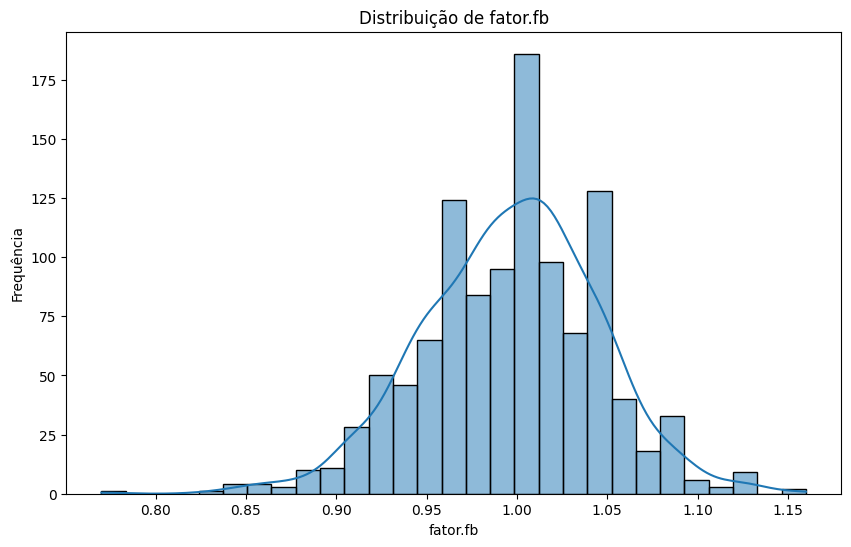

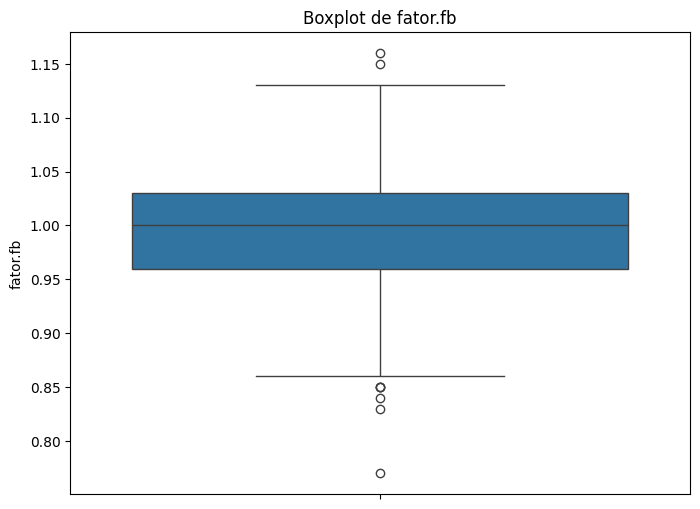

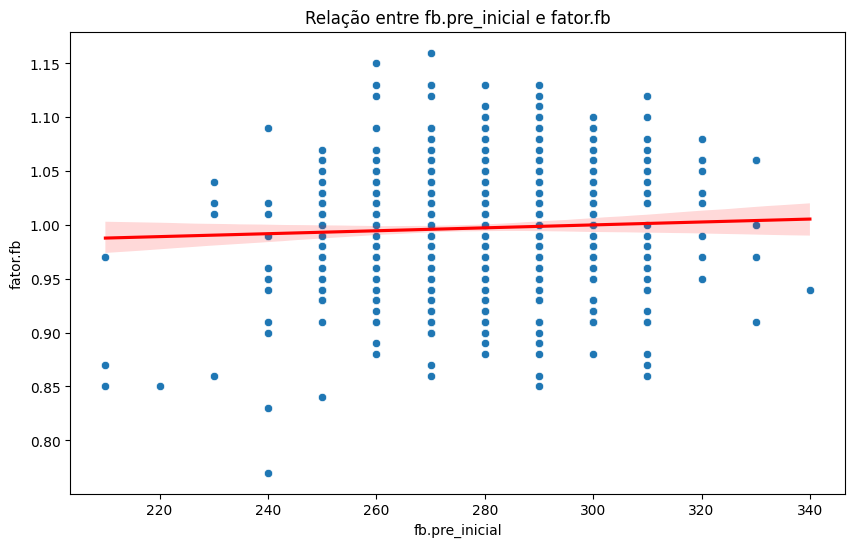

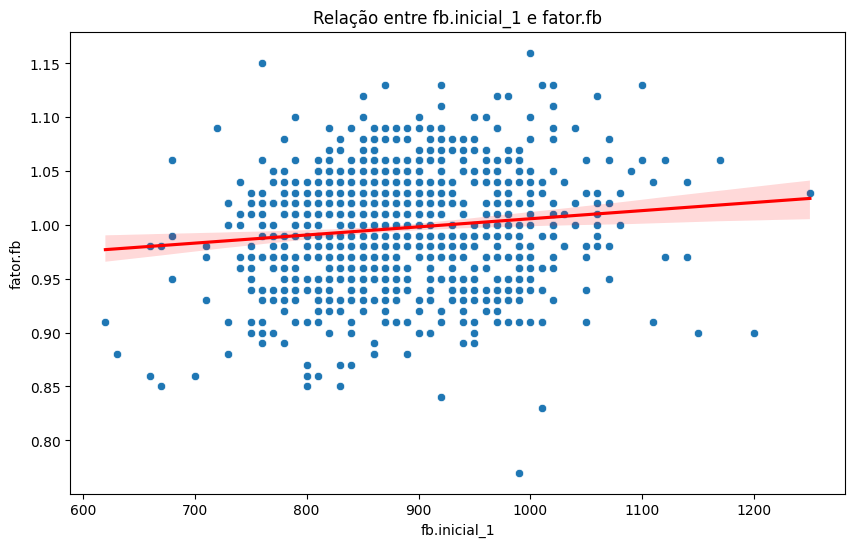

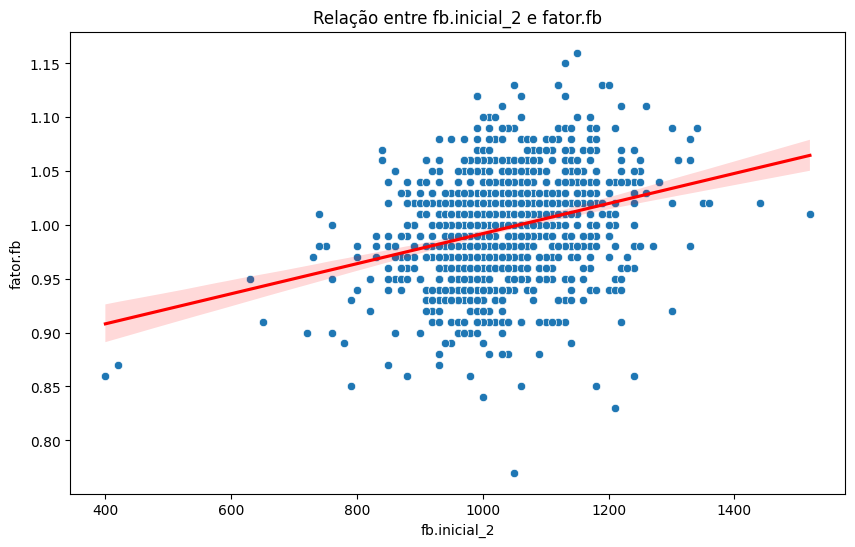

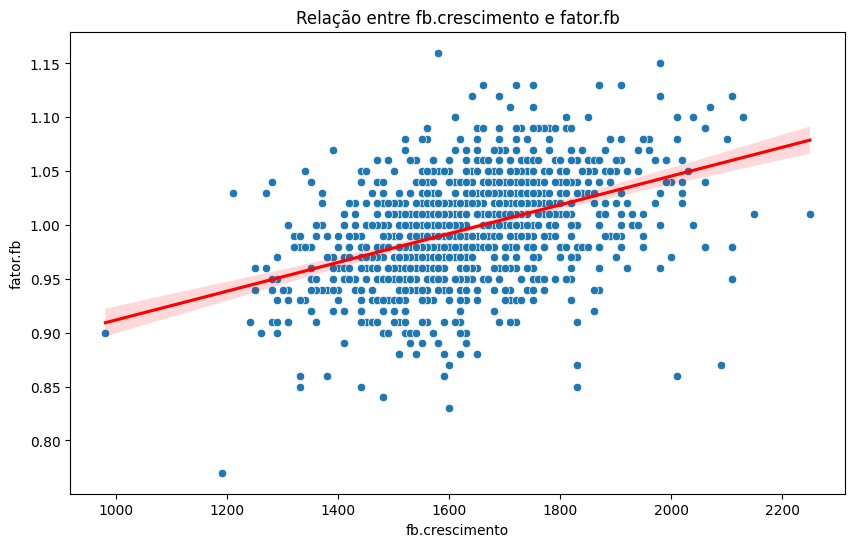

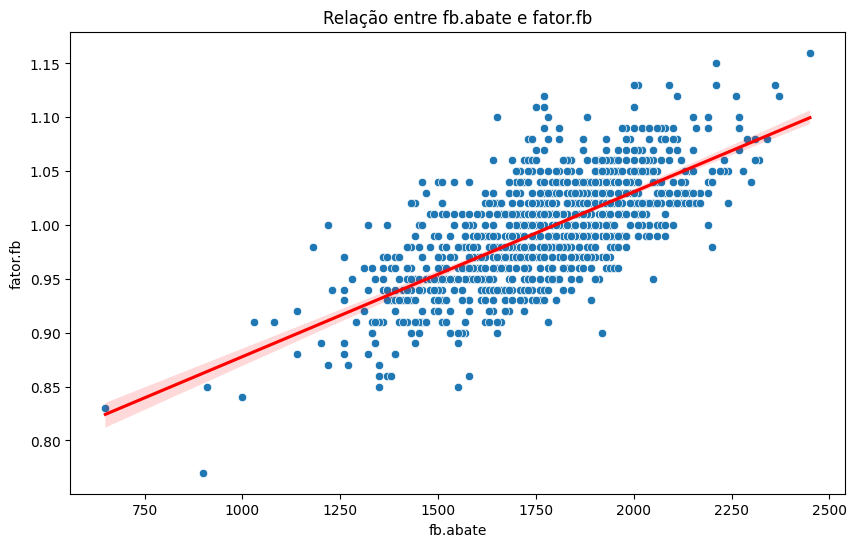

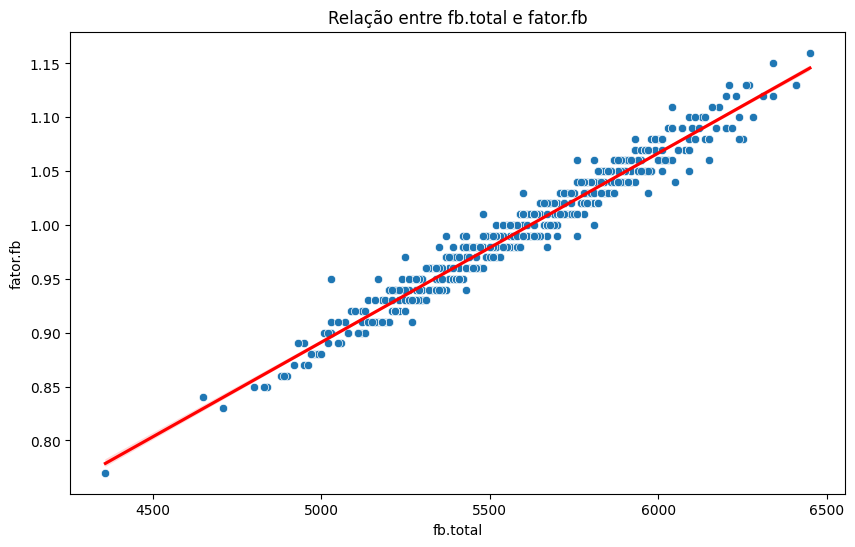

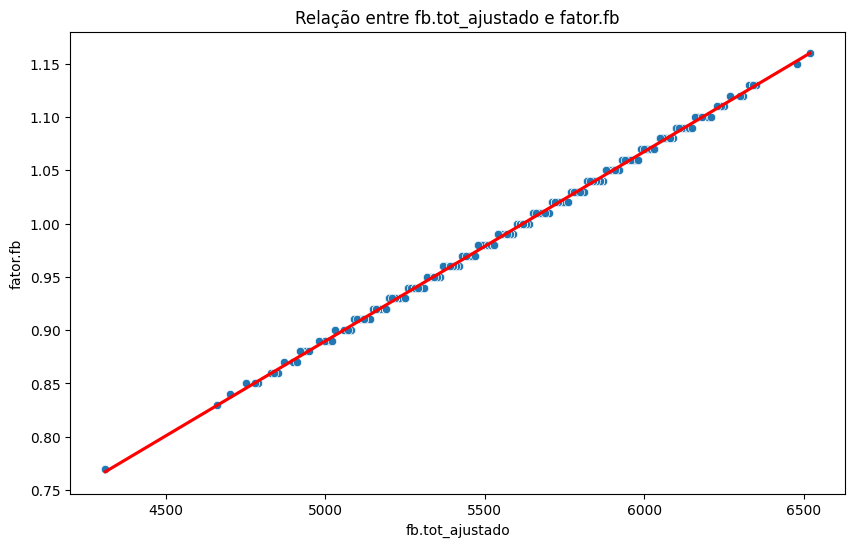

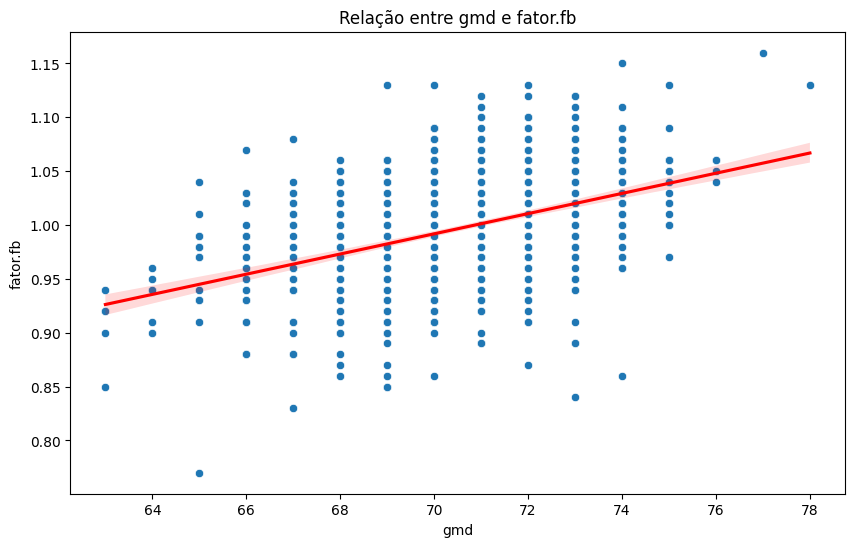

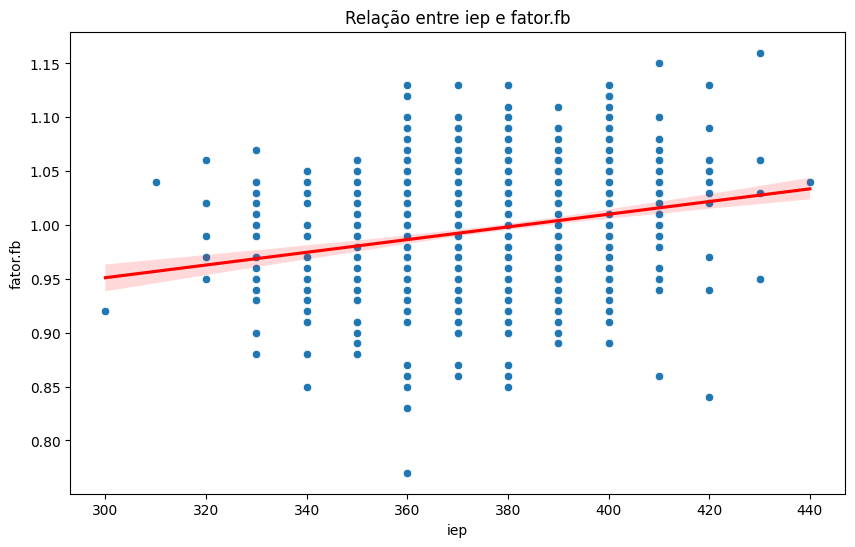

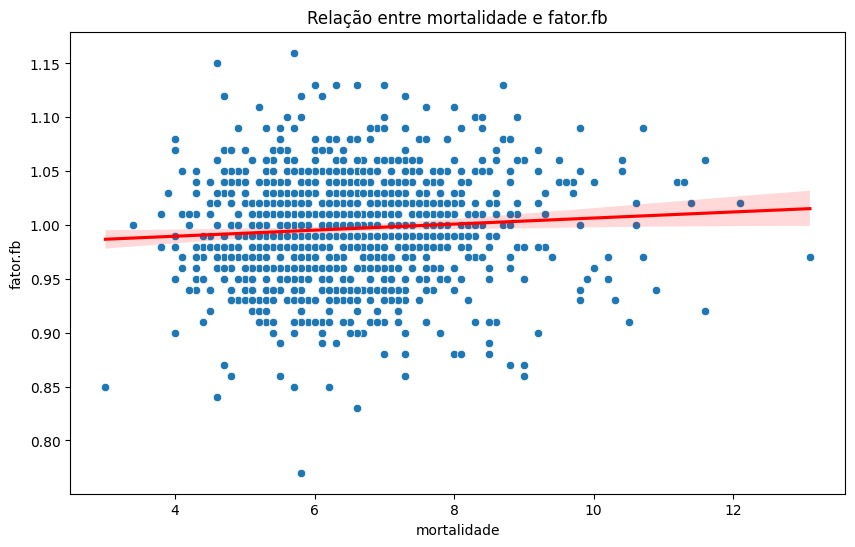

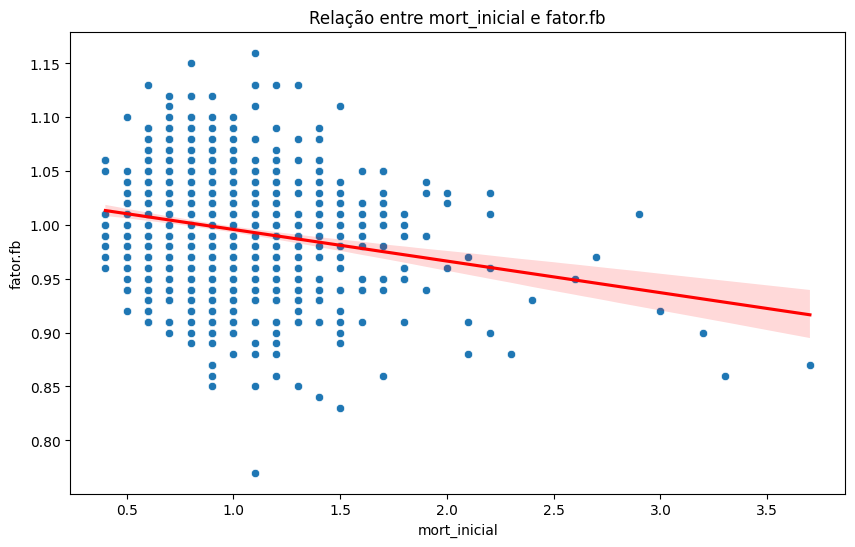

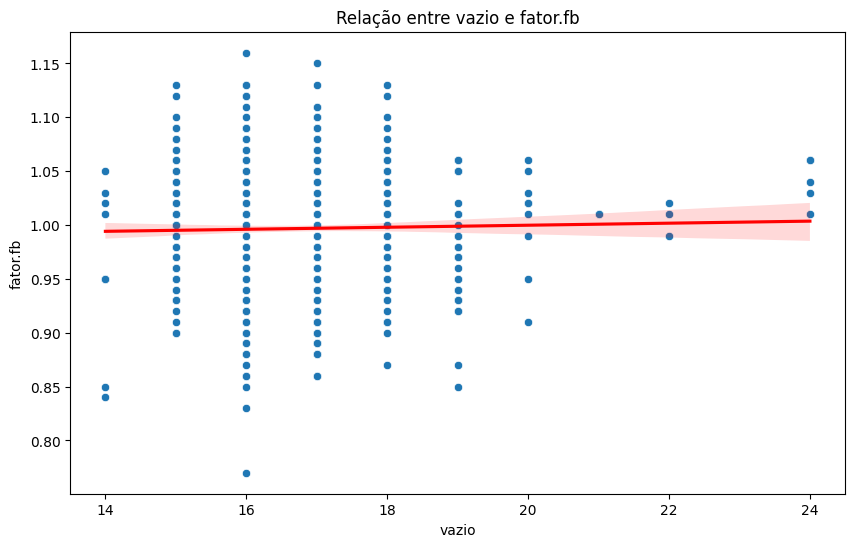

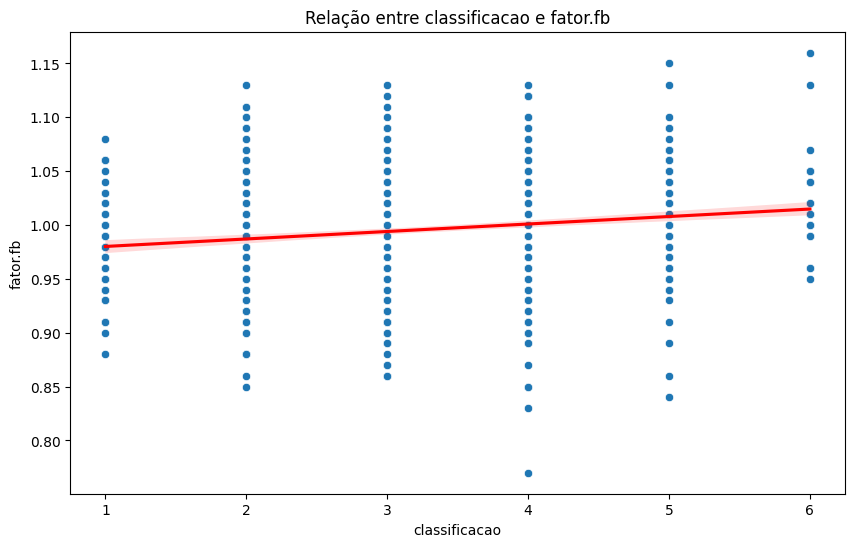

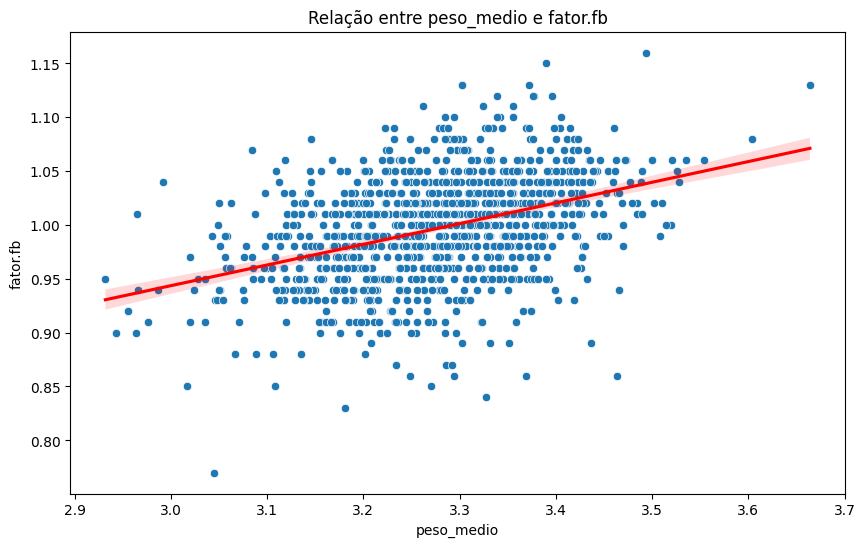

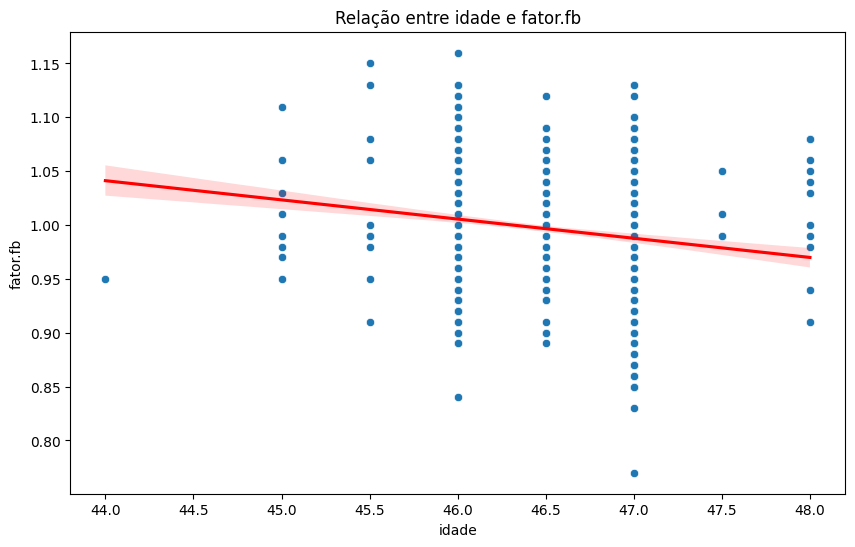

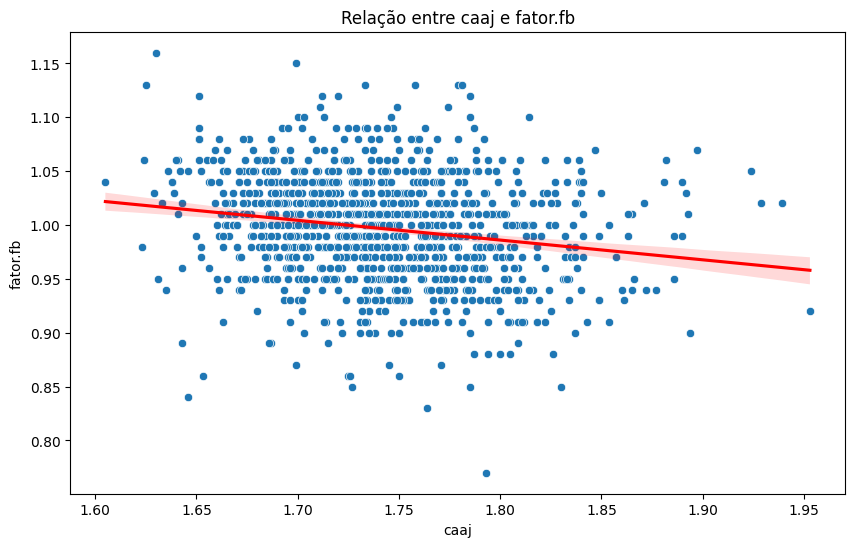

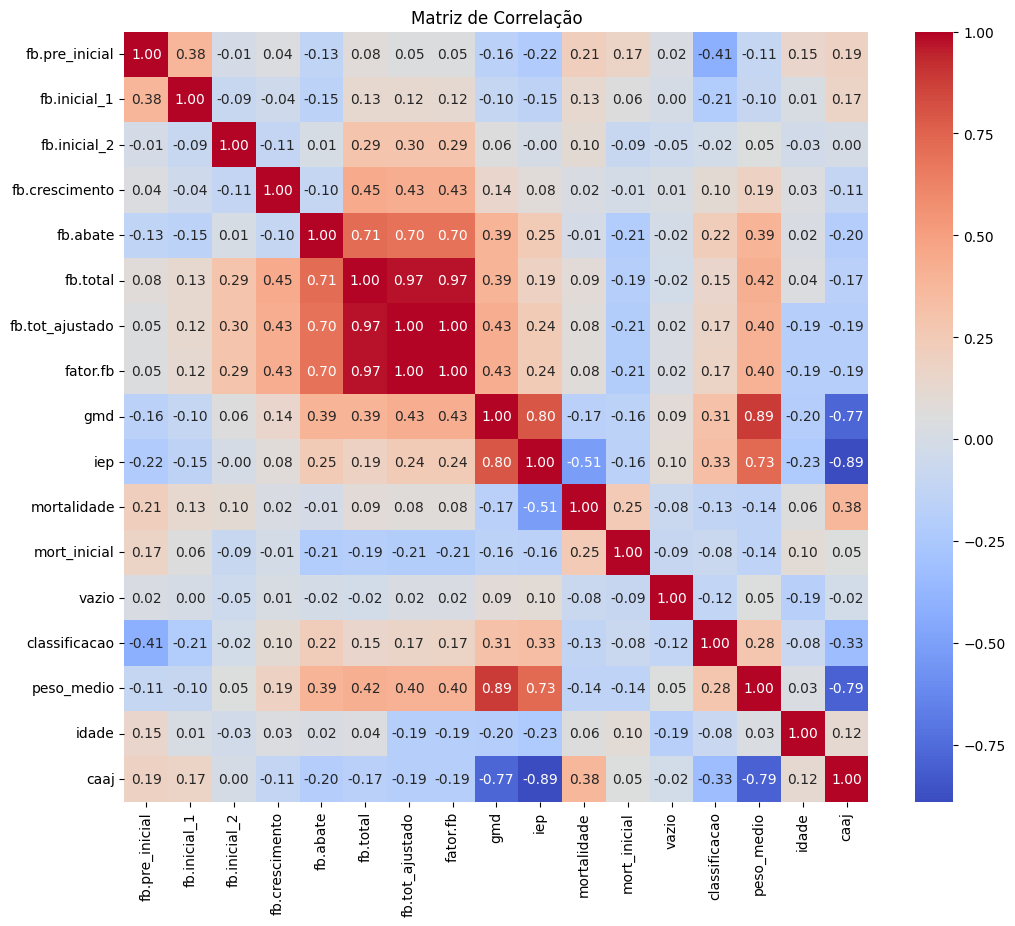


Análise de Limites de Confiança para fator.fb:
Média: 0.9967
Desvio Padrão: 0.0489
Tamanho da amostra: 1117
Intervalo de Confiança de 95%: [0.9938, 0.9995]

Teste de Normalidade (Shapiro-Wilk):
Estatística: 0.9917, p-valor: 0.000006
Os dados não seguem uma distribuição normal (α=0.05)

Percentis de fator.fb:
Percentil 1%: 0.8700
Percentil 5%: 0.9100
Percentil 10%: 0.9360
Percentil 25%: 0.9600
Percentil 50%: 1.0000
Percentil 75%: 1.0300
Percentil 90%: 1.0500
Percentil 95%: 1.0700
Percentil 99%: 1.1100


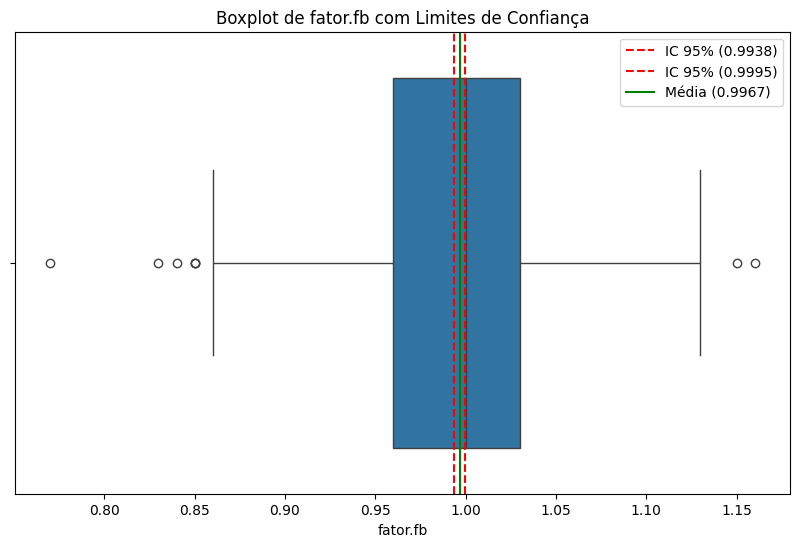

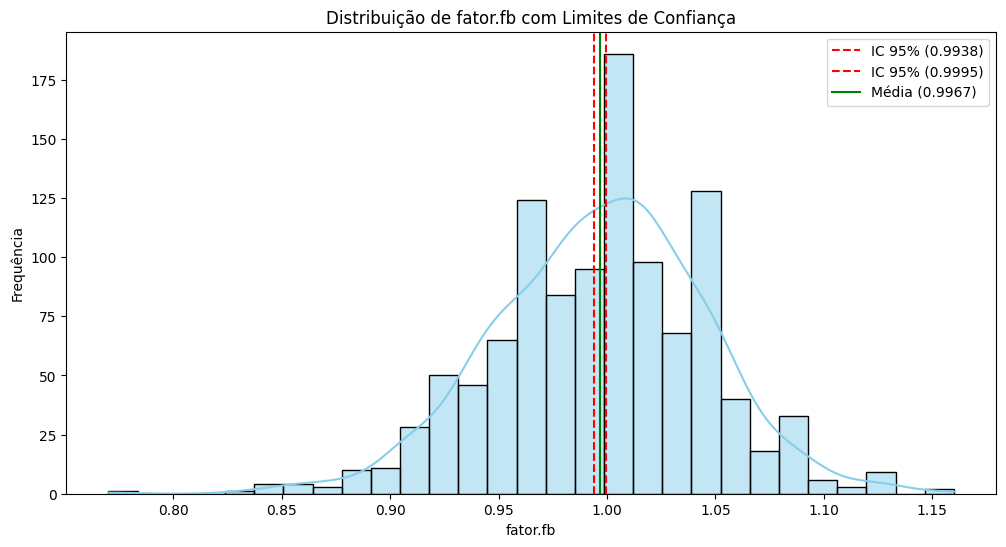

In [57]:
# Análise Exploratória de Dados (EDA) e análise das colunas em relação à variável dependente 'fator.fb'

# 1. Estatísticas Descritivas da Variável Dependente
print("Estatísticas Descritivas de 'fator.fb':")
print(df['fator.fb'].describe())

# 2. Distribuição da Variável Dependente
plt.figure(figsize=(10, 6))
sns.histplot(df['fator.fb'], kde=True)
plt.title('Distribuição de fator.fb')
plt.xlabel('fator.fb')
plt.ylabel('Frequência')
plt.show()

# 3. Boxplot da Variável Dependente
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['fator.fb'])
plt.title('Boxplot de fator.fb')
plt.ylabel('fator.fb')
plt.show()

# 4. Relação entre Variáveis Numéricas e 'fator.fb'
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in colunas_numericas:
    if col != 'fator.fb':
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df[col], y=df['fator.fb'])
        # Adiciona linha de tendência
        sns.regplot(x=df[col], y=df['fator.fb'], scatter=False, color='red')
        plt.title(f'Relação entre {col} e fator.fb')
        plt.xlabel(col)
        plt.ylabel('fator.fb')
        plt.show()

# 6. Matriz de Correlação (opcional, para verificar correlações entre todas as variáveis numéricas)
matriz_corr = df[colunas_numericas].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

# 7. Análise estatística de 'fator.fb' para determinar os limites de confiança

from scipy import stats
import numpy as np

# Calcular estatísticas básicas
media = df['fator.fb'].mean()
desvio_padrao = df['fator.fb'].std()
n = len(df['fator.fb'])

# Intervalo de confiança de 95%
# Usando a distribuição t para pequenas amostras
confianca = 0.95
graus_liberdade = n - 1
t_critico = stats.t.ppf((1 + confianca) / 2, graus_liberdade)
margem_erro = t_critico * (desvio_padrao / np.sqrt(n))

limite_inferior = media - margem_erro
limite_superior = media + margem_erro

print(f"\nAnálise de Limites de Confiança para fator.fb:")
print(f"Média: {media:.4f}")
print(f"Desvio Padrão: {desvio_padrao:.4f}")
print(f"Tamanho da amostra: {n}")
print(f"Intervalo de Confiança de 95%: [{limite_inferior:.4f}, {limite_superior:.4f}]")

# Verificar normalidade dos dados usando teste Shapiro-Wilk
stat, p_valor = stats.shapiro(df['fator.fb'])
print(f"\nTeste de Normalidade (Shapiro-Wilk):")
print(f"Estatística: {stat:.4f}, p-valor: {p_valor:.6f}")
print(f"Os dados {'seguem' if p_valor > 0.05 else 'não seguem'} uma distribuição normal (α=0.05)")

# Calcular percentis
percentis = [1, 5, 10, 25, 50, 75, 90, 95, 99]
valores_percentis = np.percentile(df['fator.fb'], percentis)

print("\nPercentis de fator.fb:")
for p, v in zip(percentis, valores_percentis):
    print(f"Percentil {p}%: {v:.4f}")

# Visualizar com boxplot avançado
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['fator.fb'])
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f'IC 95% ({limite_inferior:.4f})')
plt.axvline(x=limite_superior, color='red', linestyle='--', label=f'IC 95% ({limite_superior:.4f})')
plt.axvline(x=media, color='green', linestyle='-', label=f'Média ({media:.4f})')
plt.title('Boxplot de fator.fb com Limites de Confiança')
plt.xlabel('fator.fb')
plt.legend()
plt.show()

# Distribuição com limites de confiança
plt.figure(figsize=(12, 6))
sns.histplot(df['fator.fb'], kde=True, color='skyblue')
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f'IC 95% ({limite_inferior:.4f})')
plt.axvline(x=limite_superior, color='red', linestyle='--', label=f'IC 95% ({limite_superior:.4f})')
plt.axvline(x=media, color='green', linestyle='-', label=f'Média ({media:.4f})')
plt.title('Distribuição de fator.fb com Limites de Confiança')
plt.xlabel('fator.fb')
plt.ylabel('Frequência')
plt.legend()
plt.show()

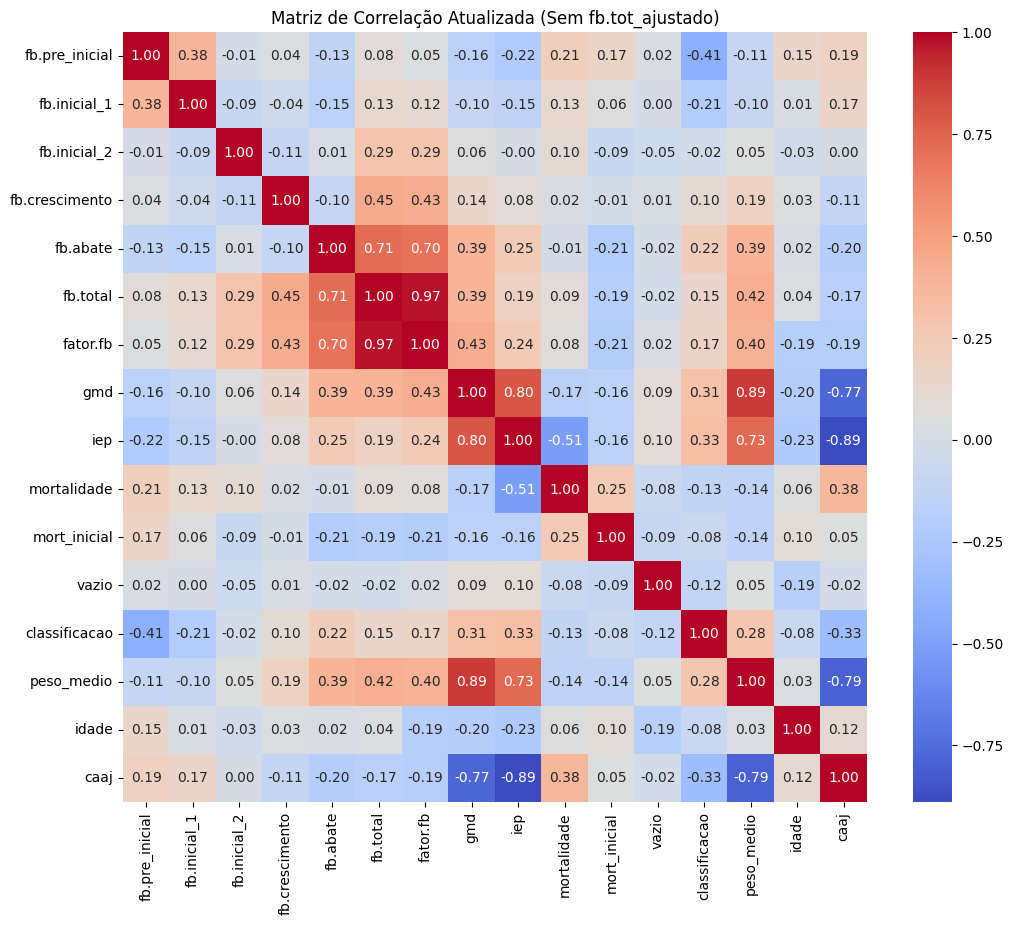

Colunas com correlação forte (>=0.2) com fator.fb:
fator.fb          1.000000
fb.total          0.970851
fb.abate          0.696118
fb.crescimento    0.430703
gmd               0.429270
peso_medio        0.402822
fb.inicial_2      0.291927
iep               0.242886
mort_inicial      0.208255
Name: fator.fb, dtype: float64

Dataframe filtrado com apenas colunas relevantes:
(1117, 10)
   fb.inicial_2  fb.crescimento  fb.abate  fb.total  fator.fb  gmd  iep  \
0          1030            1750      1810      5700      1.00   72  380   
1          1170            1730      1670      5590      1.01   70  370   
2          1180            1740      1590      5540      1.00   70  370   
3          1040            1570      2030      5840      1.05   70  370   
4           930            1850      1910      5900      1.05   71  380   

   mort_inicial  peso_medio fazenda  
0           1.1       3.408    1000  
1           0.9       3.258    1001  
2           0.9       3.233    1002  
3         

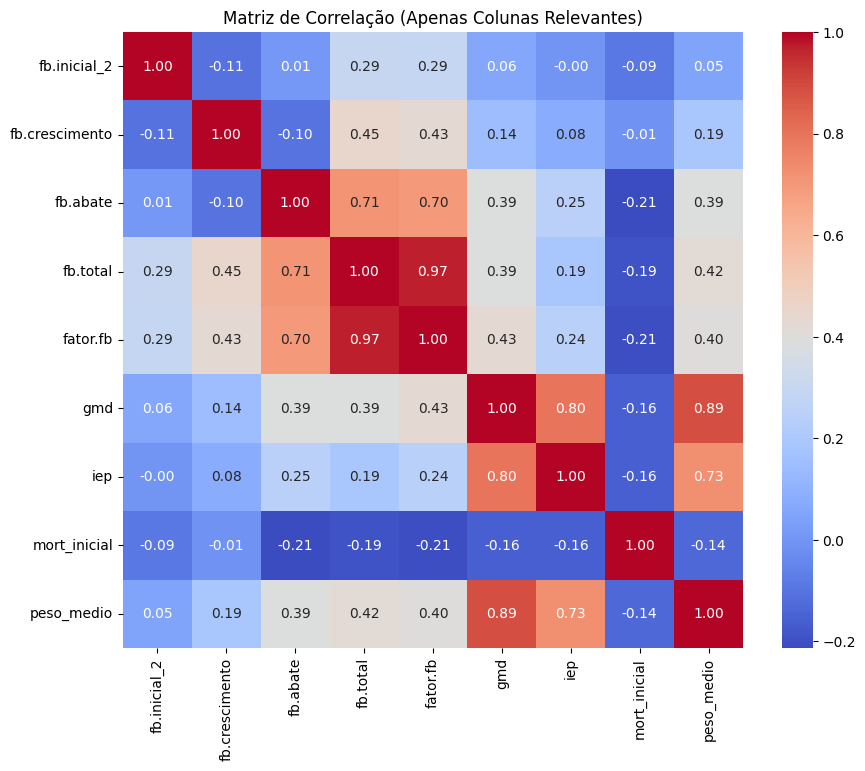

In [58]:
# Remover a coluna 'fb.tot_ajustado' do dataframe principal
df.drop(columns=['fb.tot_ajustado'], inplace=True)

# Atualizar a matriz de correlação após a remoção da coluna
matriz_corr = df.select_dtypes(include=['int64', 'float64']).corr()

# Exibir a matriz de correlação atualizada
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação Atualizada (Sem fb.tot_ajustado)')
plt.show()

# Filtrar colunas relevantes com base na correlação com 'fator.fb'
correlacoes = matriz_corr['fator.fb'].abs()
colunas_relevantes = correlacoes[correlacoes >= 0.2].index.tolist()

# Exibir as colunas com correlação >= 0.2 com fator.fb
print("Colunas com correlação forte (>=0.2) com fator.fb:")
print(correlacoes[correlacoes >= 0.2].sort_values(ascending=False))

# Adicionando a coluna 'fator.fb' se ainda não estiver na lista
if 'fator.fb' not in colunas_relevantes:
    colunas_relevantes.append('fator.fb')

# Criar novo dataframe apenas com as colunas relevantes
# Adicionando a coluna 'fazenda' de volta se necessário
df_filtrado = df[colunas_relevantes + ['fazenda']]

print("\nDataframe filtrado com apenas colunas relevantes:")
print(df_filtrado.shape)
print(df_filtrado.head())

# Visualizar a nova matriz de correlação com as colunas filtradas
plt.figure(figsize=(10, 8))
nova_matriz_corr = df_filtrado.drop(columns=['fazenda']).corr()
sns.heatmap(nova_matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Apenas Colunas Relevantes)')
plt.show()

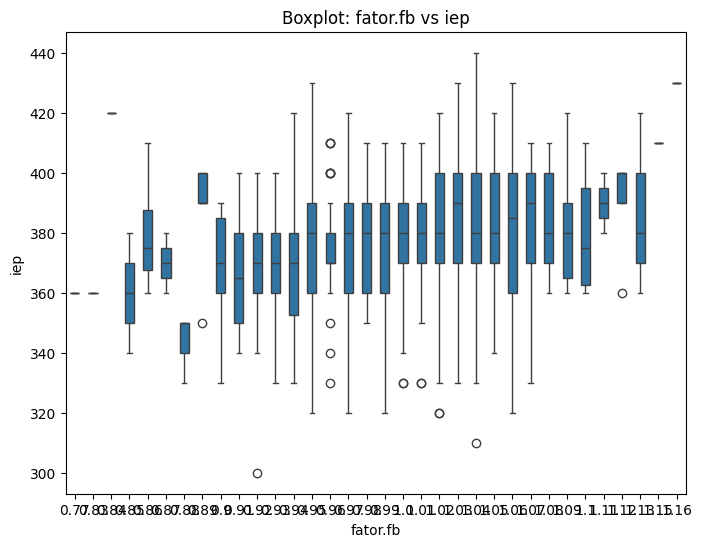

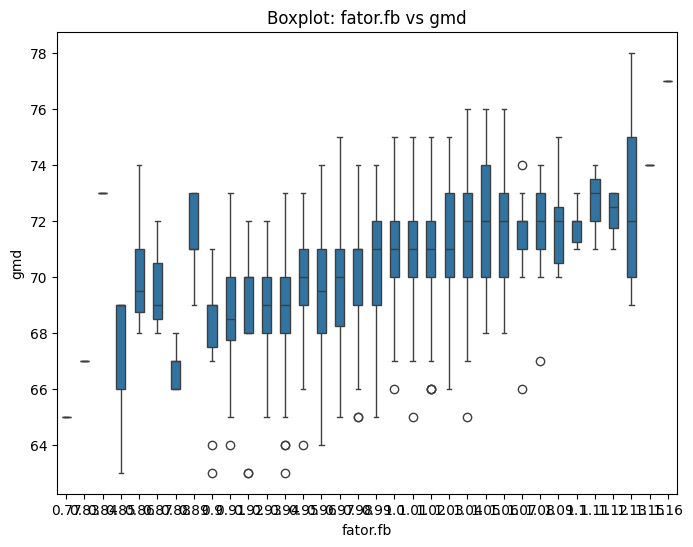

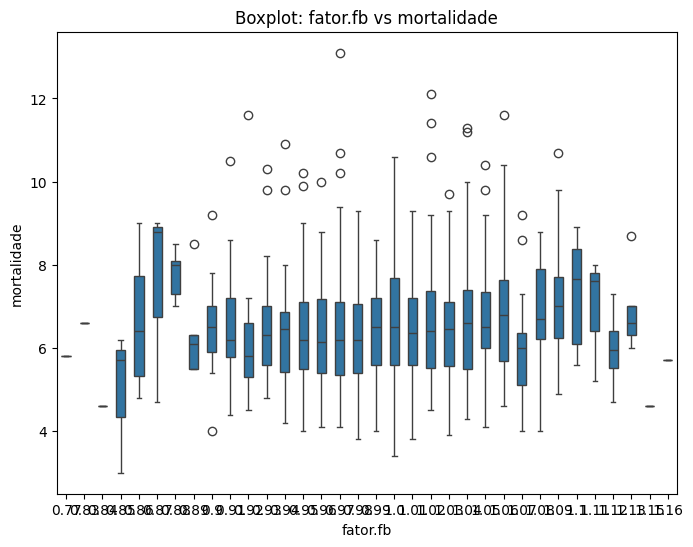

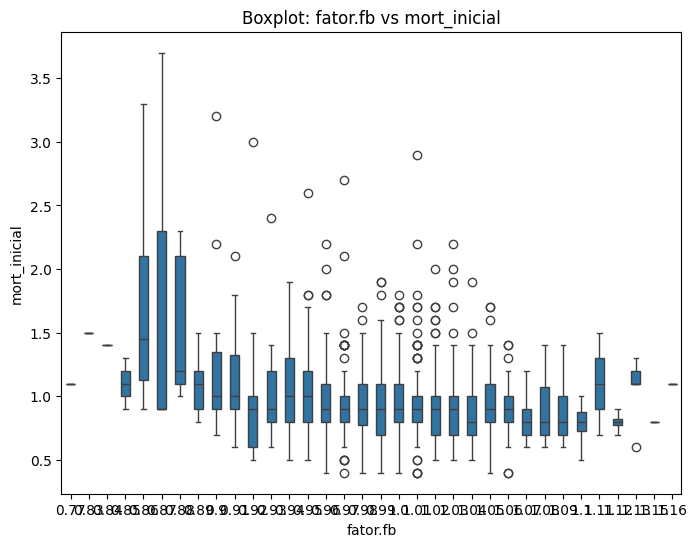

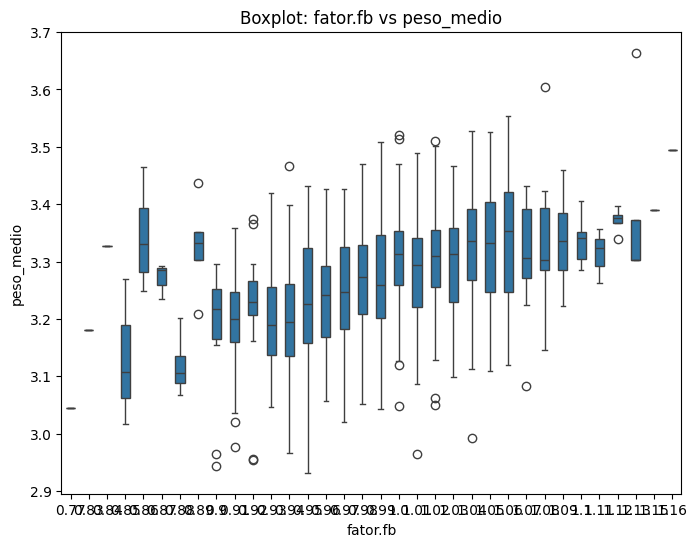

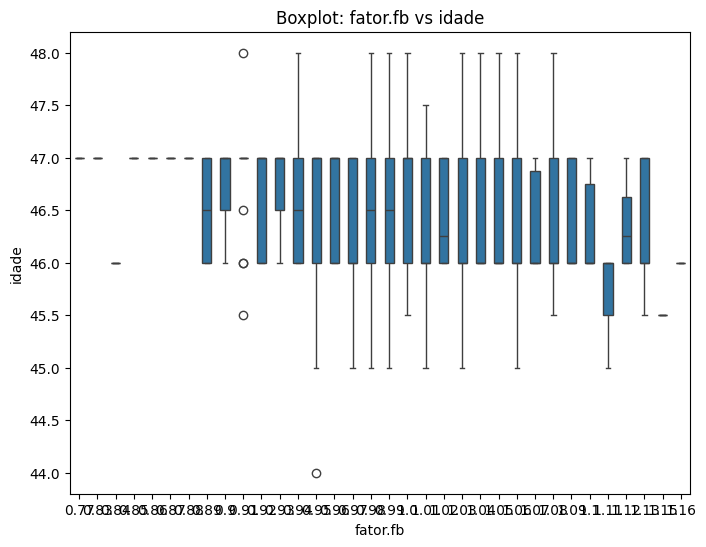

In [59]:
# Criar boxplots para analisar a relação entre 'fator.fb' e as variáveis 'iep', 'gmd', 'mortalidade', 'mort_inicial', 'peso_medio'

variaveis = ['iep', 'gmd', 'mortalidade', 'mort_inicial', 'peso_medio', 'idade']

for var in variaveis:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='fator.fb', y=var, data=df, width=0.5)  # Aumentar o tamanho do box para 0.5
    plt.title(f'Boxplot: fator.fb vs {var}')
    plt.xlabel('fator.fb')
    plt.ylabel(var)
    plt.show()


Dataframe filtrado com colunas com correlação >= 0.5:
   fb.abate  fb.total  fator.fb
0      1810      5700      1.00
1      1670      5590      1.01
2      1590      5540      1.00
3      2030      5840      1.05
4      1910      5900      1.05


<Figure size 1200x1000 with 0 Axes>

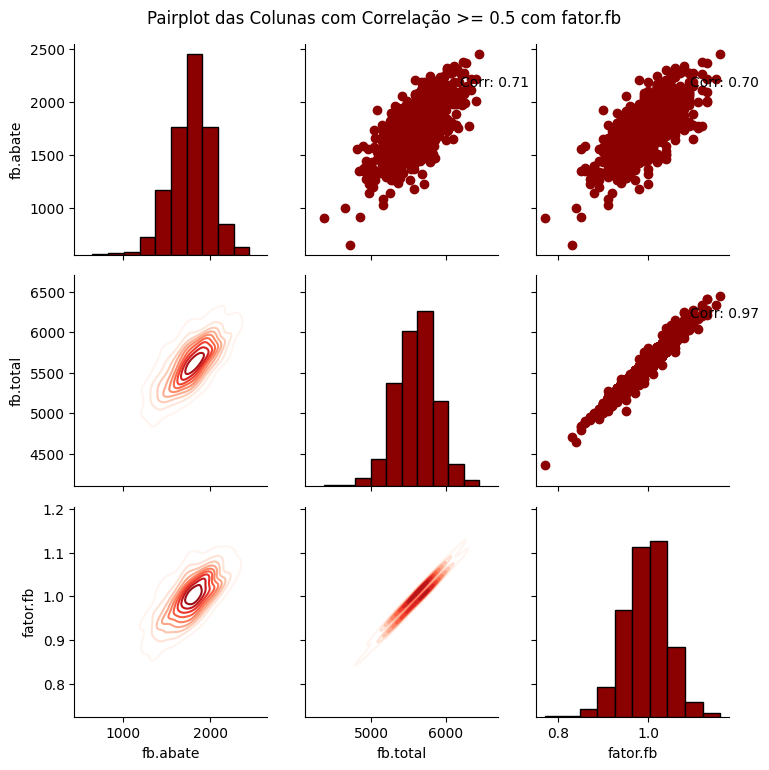

In [60]:
# Filtrar colunas relevantes com base na correlação com 'fator.fb'
correlacoes = matriz_corr['fator.fb'].abs()
colunas_relevantes = correlacoes[correlacoes >= 0.5].index.tolist()

# Adicionando a coluna 'fator.fb' se ainda não estiver na lista
if 'fator.fb' not in colunas_relevantes:
    colunas_relevantes.append('fator.fb')

# Criar novo dataframe apenas com as colunas relevantes
df_filtrado_v2 = df[colunas_relevantes].copy()

# Exibir as primeiras linhas do dataframe filtrado
print("Dataframe filtrado com colunas com correlação >= 0.5:")
print(df_filtrado_v2.head())

# Calcular a matriz de correlação
corr_matrix = df_filtrado_v2.corr()

# Criar o pairplot
plt.figure(figsize=(12, 10))  # Ajuste o tamanho conforme necessário
grid = sns.PairGrid(df_filtrado_v2)
grid = grid.map_upper(plt.scatter, color='darkred')
grid = grid.map_lower(sns.kdeplot, cmap='Reds')
grid = grid.map_diag(plt.hist, bins=10, color='darkred', edgecolor='k')

# Adicionar os valores de correlação
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        ax = grid.axes[i, j]
        correlation = corr_matrix.iloc[i, j]
        ax.text(0.8, 0.8, f'Corr: {correlation:.2f}', transform=ax.transAxes, color='black', fontsize=10)

plt.suptitle('Pairplot das Colunas com Correlação >= 0.5 com fator.fb', y=1.02)
plt.show()

In [61]:
import numpy as np

correlacao = nova_matriz_corr.loc['fator.fb', 'fb.total']
r_squared = np.square(correlacao)

print(f"Correlação entre fator.fb e fb.total: {correlacao:.4f}")
print(f"R-squared (quanto fator.fb explica fb.total): {r_squared:.4f}")

Correlação entre fator.fb e fb.total: 0.9709
R-squared (quanto fator.fb explica fb.total): 0.9426


In [62]:
# Selecionar colunas de interesse
X = df_filtrado[['fator.fb']]
y = df_filtrado['fb.total']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliar o modelo
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = rf_model.score(X_test, y_test)

print("MSE:", mse)
print("R²:", r2)

MSE: 4218.487184454733
R²: 0.9300540977864844


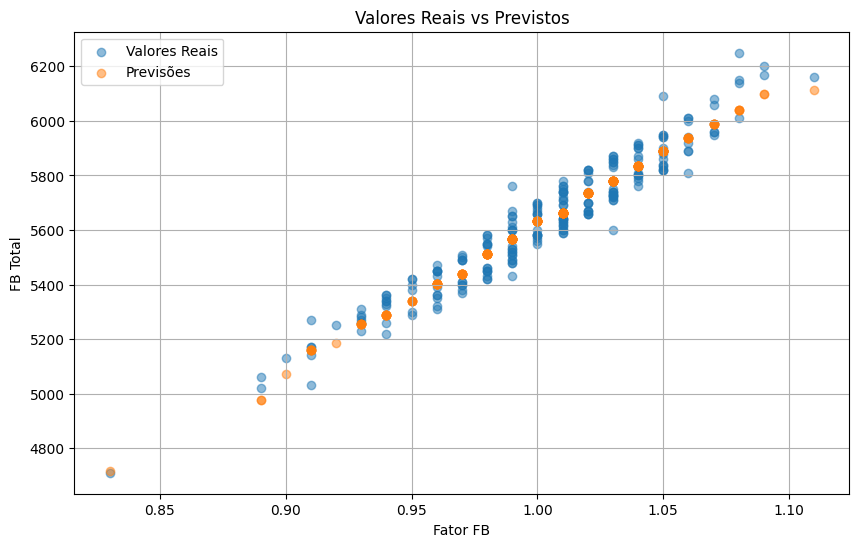

Coeficiente (inclinação): 5363.95
Intercepto: 253.97
Equação: fb.total = 5363.95 * fator.fb + 253.97


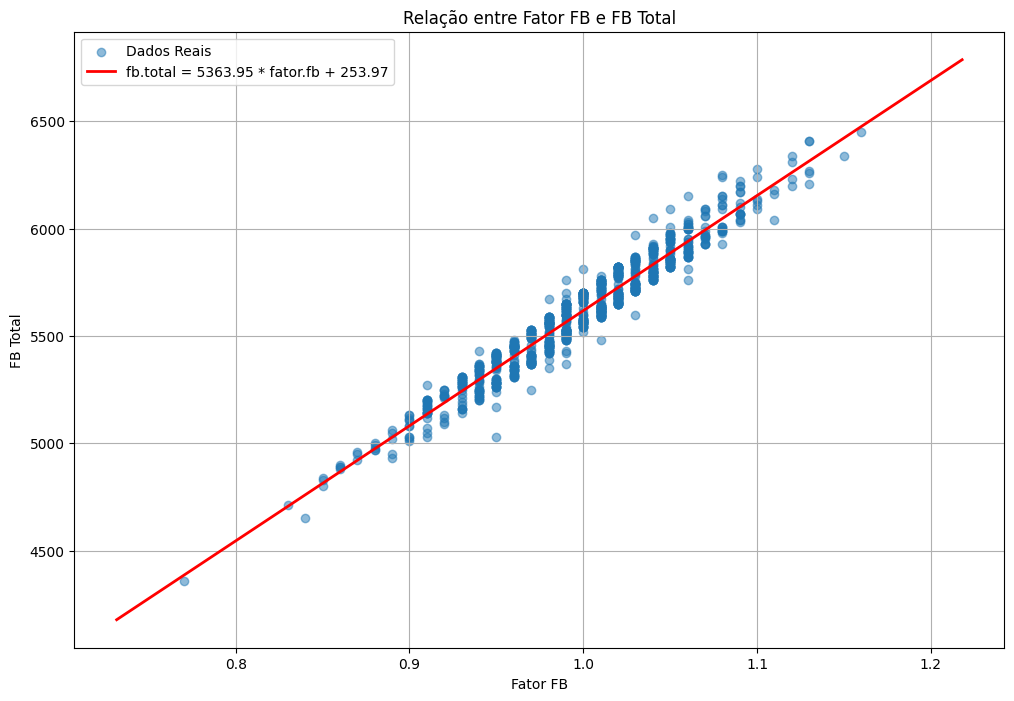

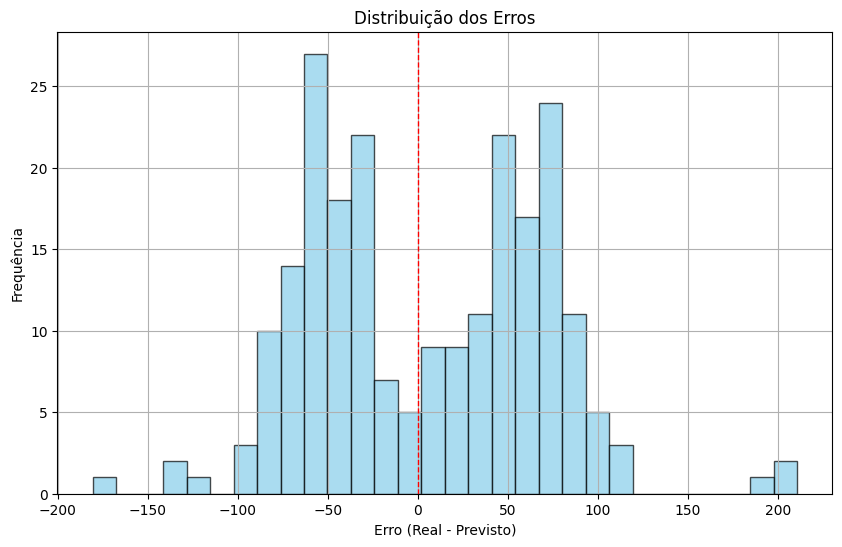

Erro médio: 5.24
Erro absoluto médio: 56.77
Erro percentual médio: 1.01%


In [63]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Vamos ampliar o modelo para entender melhor a relação entre fator.fb e fb.total
# Primeiro, criamos um modelo linear simples para visualizar a relação
import matplotlib.pyplot as plt

# Comparação entre os valores reais e previstos da amostra de teste
plt.figure(figsize=(10, 6))
plt.scatter(X_test['fator.fb'], y_test, alpha=0.5, label='Valores Reais')
plt.scatter(X_test['fator.fb'], predictions, alpha=0.5, label='Previsões')
plt.xlabel('Fator FB')
plt.ylabel('FB Total')
plt.title('Valores Reais vs Previstos')
plt.legend()
plt.grid(True)
plt.show()

# Criar um modelo linear para visualizar os coeficientes
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Obter os coeficientes e o intercepto
coef = linear_model.coef_[0]
intercept = linear_model.intercept_

# Exibir os coeficientes
print(f"Coeficiente (inclinação): {coef:.2f}")
print(f"Intercepto: {intercept:.2f}")
print(f"Equação: fb.total = {coef:.2f} * fator.fb + {intercept:.2f}")

# Criar uma linha de tendência para visualização
x_range = np.linspace(X['fator.fb'].min() * 0.95, X['fator.fb'].max() * 1.05, 100)
y_pred = coef * x_range + intercept

# Plotar os dados reais e a linha de tendência
plt.figure(figsize=(12, 8))
plt.scatter(df['fator.fb'], df['fb.total'], alpha=0.5, label='Dados Reais')
plt.plot(x_range, y_pred, color='red', linewidth=2, label=f'fb.total = {coef:.2f} * fator.fb + {intercept:.2f}')
plt.xlabel('Fator FB')
plt.ylabel('FB Total')
plt.title('Relação entre Fator FB e FB Total')
plt.legend()
plt.grid(True)
plt.show()

# Análise de erros
erros = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(erros, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')
plt.grid(True)
plt.show()

# Calcular estatísticas de erro
erro_medio = erros.mean()
erro_absoluto = abs(erros).mean()
erro_percentual = (abs(erros) / y_test * 100).mean()

print(f"Erro médio: {erro_medio:.2f}")
print(f"Erro absoluto médio: {erro_absoluto:.2f}")
print(f"Erro percentual médio: {erro_percentual:.2f}%")

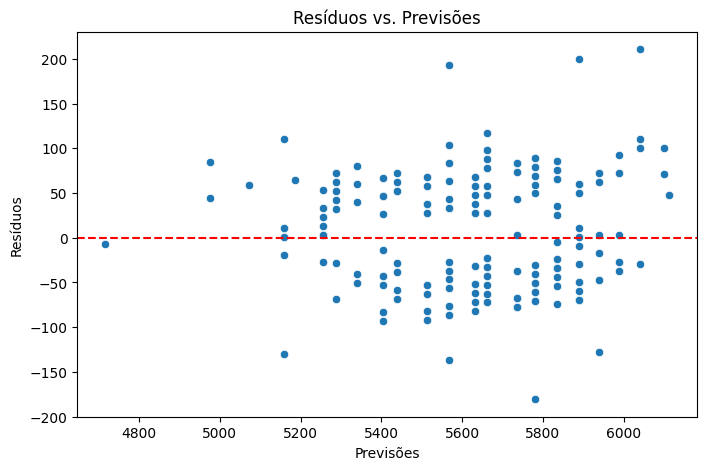

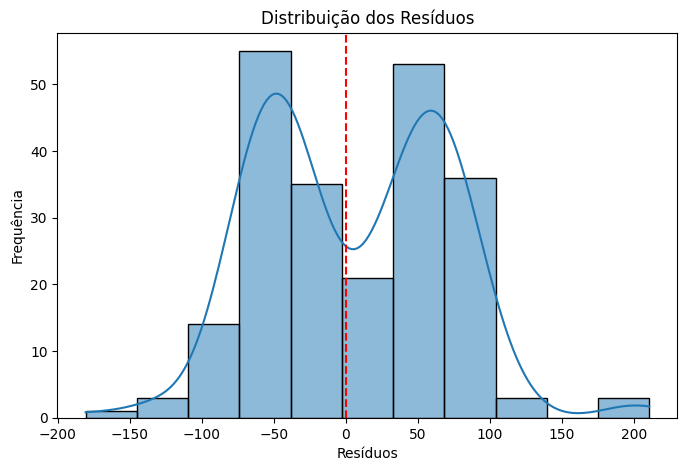

Resíduo Médio: 5.24
Desvio Padrão dos Resíduos: 64.88


In [64]:
# Análise de Resíduos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=predictions, y=erros)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Resíduos vs. Previsões')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

# Distribuição dos Resíduos
plt.figure(figsize=(8, 5))
sns.histplot(erros, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

print(f"Resíduo Médio: {erros.mean():.2f}")
print(f"Desvio Padrão dos Resíduos: {erros.std():.2f}")

Discretized Accuracy: 90.62%

Classification Report:
              precision    recall  f1-score   support

   4500-5000       0.33      1.00      0.50         1
   5000-5500       0.98      0.78      0.87        67
   5500-6000       0.89      0.99      0.94       144
   6000-6500       1.00      0.58      0.74        12

    accuracy                           0.91       224
   macro avg       0.80      0.84      0.76       224
weighted avg       0.92      0.91      0.90       224



ValueError: array length 224 does not match index length 400

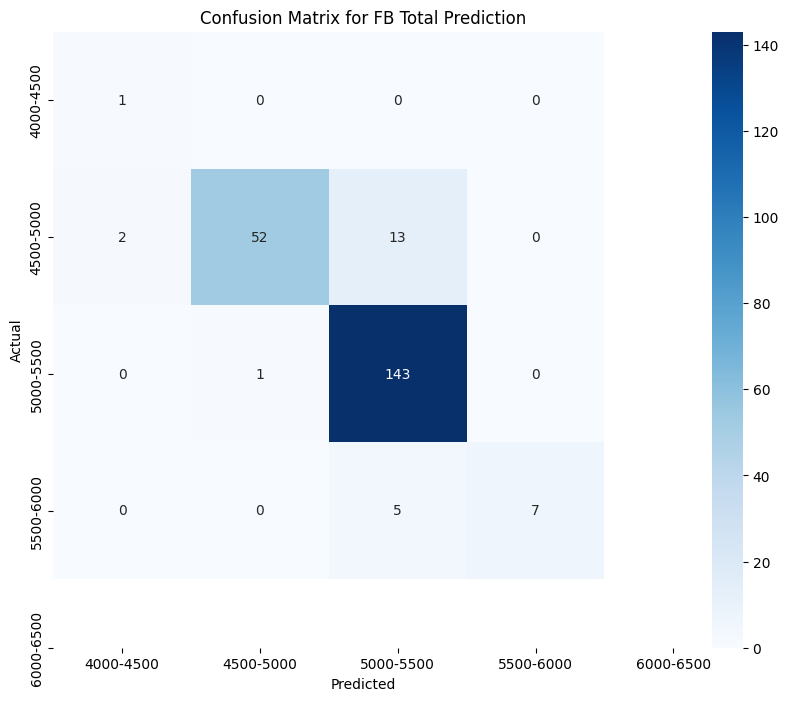

<Figure size 1000x600 with 0 Axes>

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# Define bins for discretizing the predictions and actual values
# This will allow us to treat the regression as a classification problem for confusion matrix
bins = [4000, 4500, 5000, 5500, 6000, 6500]
labels = ["4000-4500", "4500-5000", "5000-5500", "5500-6000", "6000-6500"]

# Discretize the predictions and actual values
y_test_discrete = pd.cut(y_test, bins=bins, labels=labels)
pred_discrete = pd.cut(pd.Series(predictions), bins=bins, labels=labels)

# Create confusion matrix
cm = confusion_matrix(y_test_discrete, pred_discrete)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FB Total Prediction')

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Discretized Accuracy: {accuracy:.2%}")

# Calculate classification metrics for each bin
print("\nClassification Report:")
print(classification_report(y_test_discrete, pred_discrete))

# Additional analysis: show error distribution by predicted bin
plt.figure(figsize=(10, 6))
error_by_category = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Error': y_test - predictions,
    'Category': pred_discrete
})

sns.boxplot(x='Category', y='Error', data=error_by_category)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Error Distribution by Predicted FB Total Range')
plt.xlabel('Predicted FB Total Range')
plt.ylabel('Error (Actual - Predicted)')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Gerar métricas de classificação para as categorias binned
accuracy = accuracy_score(y_test_discrete, pred_discrete)
precision = precision_score(y_test_discrete, pred_discrete, average='weighted')
recall = recall_score(y_test_discrete, pred_discrete, average='weighted')
f1 = f1_score(y_test_discrete, pred_discrete, average='weighted')

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

# Exibir relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_discrete, pred_discrete))

Accuracy:  0.91
Precision: 0.92
Recall:    0.91
F1-score:  0.90

Classification Report:
              precision    recall  f1-score   support

   4500-5000       0.33      1.00      0.50         1
   5000-5500       0.98      0.78      0.87        67
   5500-6000       0.89      0.99      0.94       144
   6000-6500       1.00      0.58      0.74        12

    accuracy                           0.91       224
   macro avg       0.80      0.84      0.76       224
weighted avg       0.92      0.91      0.90       224



Aqui está uma explicação dos resultados de precisão, recall, f1-score e suporte:

```markdown
## Explicação das Métricas de Classificação

As métricas de precisão, recall e F1-score são usadas para avaliar o desempenho de um modelo de classificação, especialmente quando as classes não estão balanceadas.

- **Precisão (Precision)**: Das previsões que o modelo fez para uma determinada classe, qual a proporção que realmente pertence a essa classe. É a capacidade do modelo de não rotular uma instância como positiva se ela for negativa.
    - Fórmula: Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)

- **Recall (Sensibilidade ou Taxa de Verdadeiros Positivos)**: Das instâncias que realmente pertencem a uma determinada classe, qual a proporção que o modelo conseguiu identificar corretamente. É a capacidade do modelo de encontrar todas as instâncias positivas.
    - Fórmula: Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

- **F1-score**: É a média harmônica entre precisão e recall. Ele fornece uma única métrica que equilibra ambos os aspectos. É útil quando você precisa de um equilíbrio entre precisão e recall.
    - Fórmula: F1-score = 2 * (Precisão * Recall) / (Precisão + Recall)

- **Suporte (Support)**: É o número de ocorrências reais da classe no conjunto de dados de teste. Ele fornece uma ideia da quantidade de amostras que o modelo teve para aprender e testar para cada classe.

### Interpretação Geral

- **Valores Altos**: Indicam que o modelo está performando bem na classe em questão. Um valor alto de precisão e recall significa que o modelo está identificando corretamente a maioria das instâncias da classe e não está cometendo muitos erros.
- **Valores Baixos**: Sugerem que o modelo está tendo dificuldades com a classe. Pode ser devido a poucos exemplos de treinamento, características pouco discriminativas ou desbalanceamento da classe.

### Análise Detalhada

Para uma análise mais aprofundada, é importante considerar o contexto do problema e o impacto de falsos positivos e falsos negativos. Por exemplo:

- **Alta Precisão e Baixo Recall**: O modelo é cauteloso ao prever a classe, mas perde muitas instâncias reais.
- **Baixa Precisão e Alto Recall**: O modelo prevê a classe com frequência, mas comete muitos erros.

O F1-score ajuda a equilibrar essas situações, mas a escolha da métrica mais importante depende dos objetivos do problema.
```

#Comparação com dados dos sensores para encontrar alguns padrões

## Recaptulando o arquivo baixado
## Importar o CSV com codificação UTF-8 e separação por ponto e vírgula
df = pd.read_csv('database_05_05_2025.csv', encoding='utf-8', sep=';', on_bad_lines='skip', dtype=str)

# Importar dados tratador por aviario

In [66]:
# Importar dados do arquivo de sensores
import pandas as pd

sensores_df = pd.read_csv('dados_combinados.csv', encoding='utf-8', sep=';')

print("Dados dos sensores importados:", sensores_df.shape)
print(sensores_df.head())

# Corrigir caso as colunas estejam concatenadas em uma única string
if sensores_df.shape[1] == 1 and ',' in str(sensores_df.iloc[0, 0]):
    colunas = sensores_df.columns[0].split(',')
    dados_separados = sensores_df.iloc[:, 0].str.split(',', expand=True)
    if len(colunas) == len(dados_separados.columns):
        dados_separados.columns = colunas
    else:
        dados_separados.columns = [f'coluna_{i}' for i in range(dados_separados.shape[1])]
    sensores_df = dados_separados

# Identificar colunas categóricas e numéricas
colunas_categoricas = ['aviario', 'feed_phase']
colunas_para_conversao = []

for col in sensores_df.columns:
    if col not in colunas_categoricas:
        colunas_para_conversao.append(col)

# Converter colunas para formato numérico (substituir vírgulas por pontos)
for col in colunas_para_conversao:
    try:
        if sensores_df[col].dtype == 'object':
            sensores_df[col] = sensores_df[col].str.replace(',', '.', regex=False)
            sensores_df[col] = pd.to_numeric(sensores_df[col], errors='coerce')
    except Exception as e:
        print(f"Não foi possível converter a coluna {col}: {e}")

print("Dados dos sensores estruturados:")
print(sensores_df.head())
print("\nTipos de dados:")
print(sensores_df.dtypes)

# Agregar apenas colunas numéricas por aviario e por fase de alimentação
if 'aviario' in sensores_df.columns:
    colunas_numericas = sensores_df.select_dtypes(include=['number']).columns

    # Dividir o dataframe por fase de alimentação para análise separada
    feed_phases = sensores_df['feed_phase'].unique() if 'feed_phase' in sensores_df.columns else [None]
    dados_por_fase = {}

    for phase in feed_phases:
        if phase:
            phase_data = sensores_df[sensores_df['feed_phase'] == phase]
            phase_prefix = phase.split(' - ')[1].lower().replace(' ', '_') if ' - ' in phase else 'unknown'
            dados_por_fase[phase_prefix] = phase_data

    print(f"\nFases de alimentação identificadas: {len(feed_phases)}")
else:
    print("Coluna 'aviario' não encontrada nos dados dos sensores")


Dados dos sensores importados: (100, 1)
  aviario,feed_phase,vel_vento,amb_temp,bed_temp,light,umidade,temp_agua,consumo_agua,eletricidade,total_racao
0  1037,1 - Pré-Inicial,1.26146483516484,29.81295...                                                          
1  1037,2 - Inicial 1,0.971915625,26.585272564571...                                                          
2  1037,3 - Inicial 2,2.76596256830601,24.5919808...                                                          
3  1037,4 - Crescimento,5.68660386904762,23.90033...                                                          
4  1037,5 - Abate,6.5774762295082,22.527246113076...                                                          
Dados dos sensores estruturados:
  aviario       feed_phase  vel_vento   amb_temp   bed_temp     light  \
0    1037  1 - Pré-Inicial   1.261465  29.812957  32.923253  3.344047   
1    1037    2 - Inicial 1   0.971916  26.585273  33.170975  8.210785   
2    1037    3 - Inicial 2   2.765963  24.

Forma dos dados: (100, 12)

Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   aviario       100 non-null    object 
 1   feed_phase    100 non-null    object 
 2   vel_vento     100 non-null    float64
 3   amb_temp      98 non-null     float64
 4   bed_temp      46 non-null     float64
 5   light         100 non-null    float64
 6   umidade       98 non-null     float64
 7   temp_agua     98 non-null     float64
 8   consumo_agua  79 non-null     float64
 9   eletricidade  81 non-null     float64
 10  total_racao   12 non-null     float64
 11  fase_num      100 non-null    int64  
dtypes: float64(9), int64(1), object(2)
memory usage: 9.5+ KB
None

Estatísticas descritivas:
        vel_vento   amb_temp   bed_temp       light    umidade  temp_agua  \
count  100.000000  98.000000  46.000000  100.000000  98.000000  98.00000

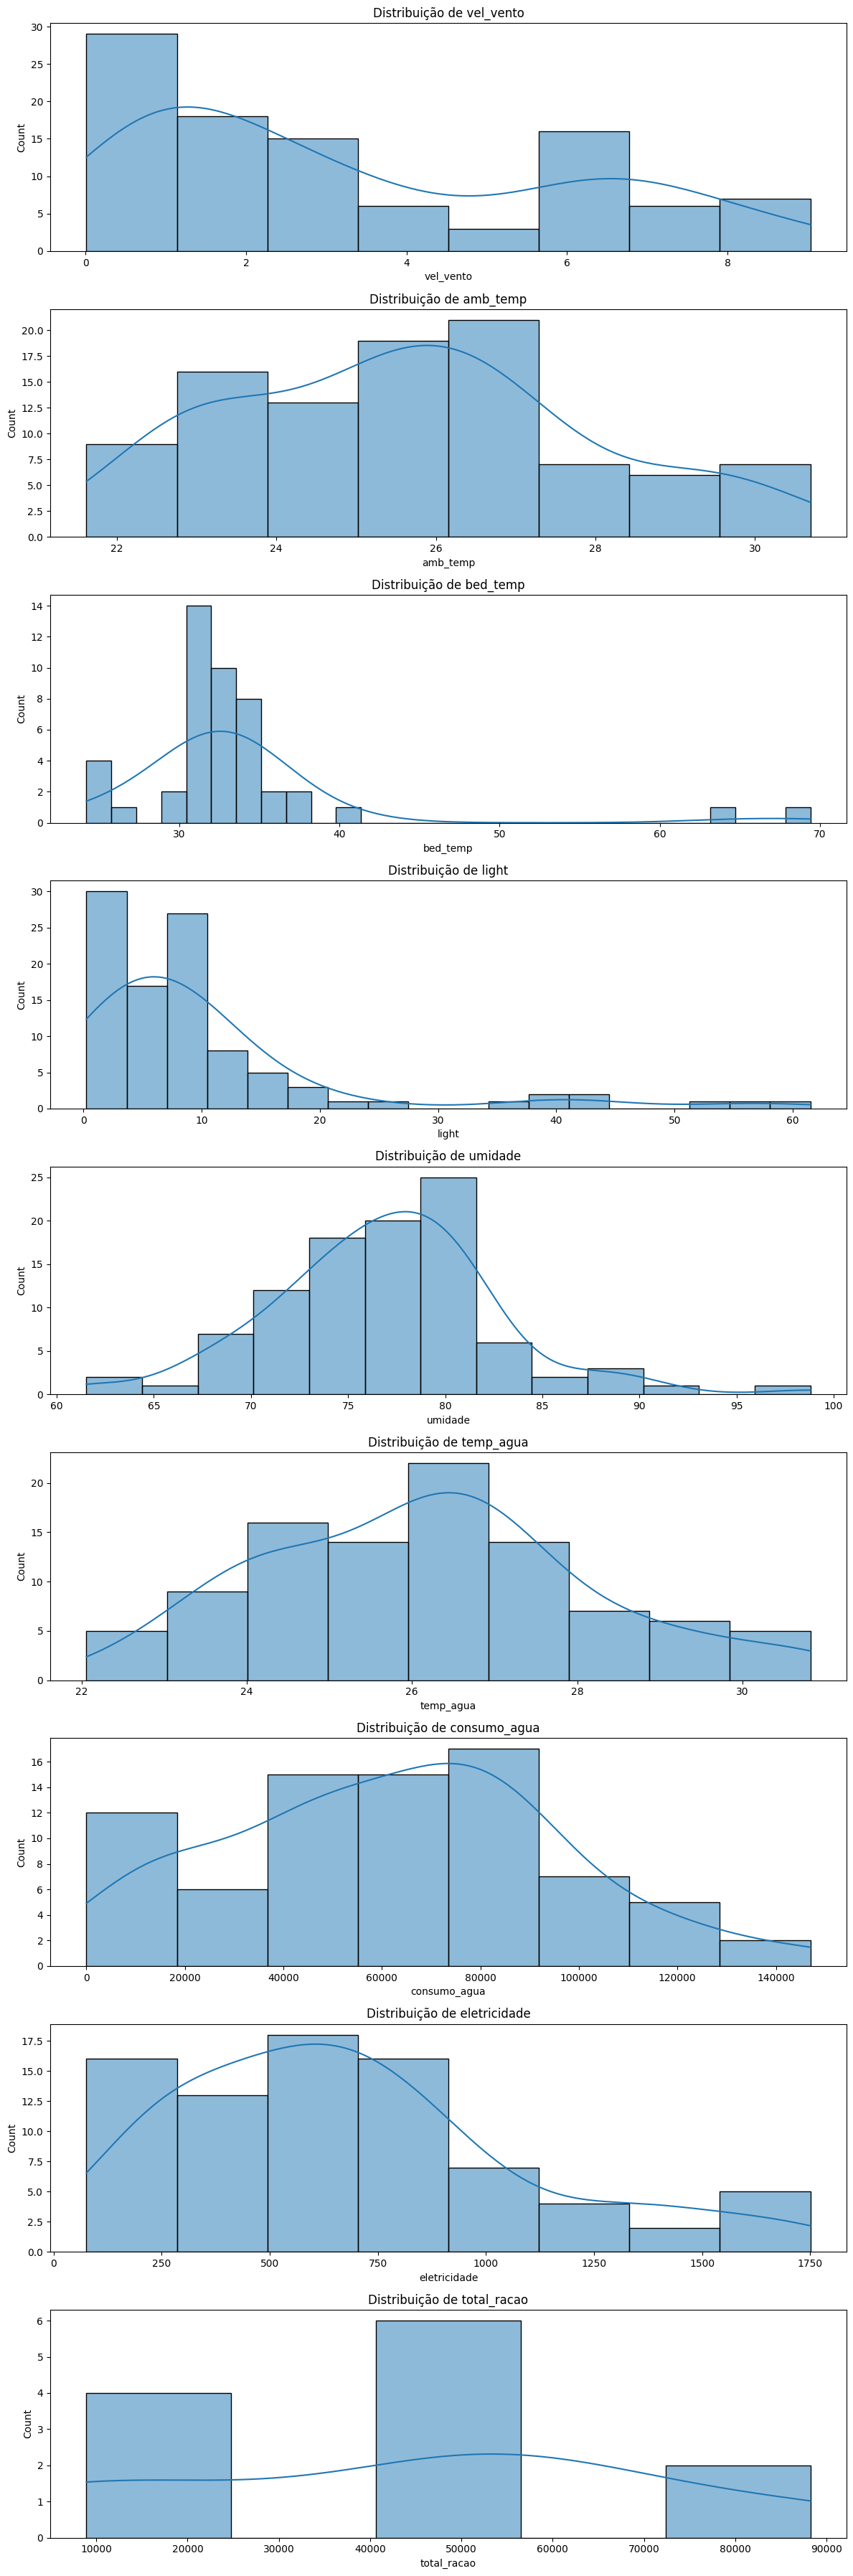

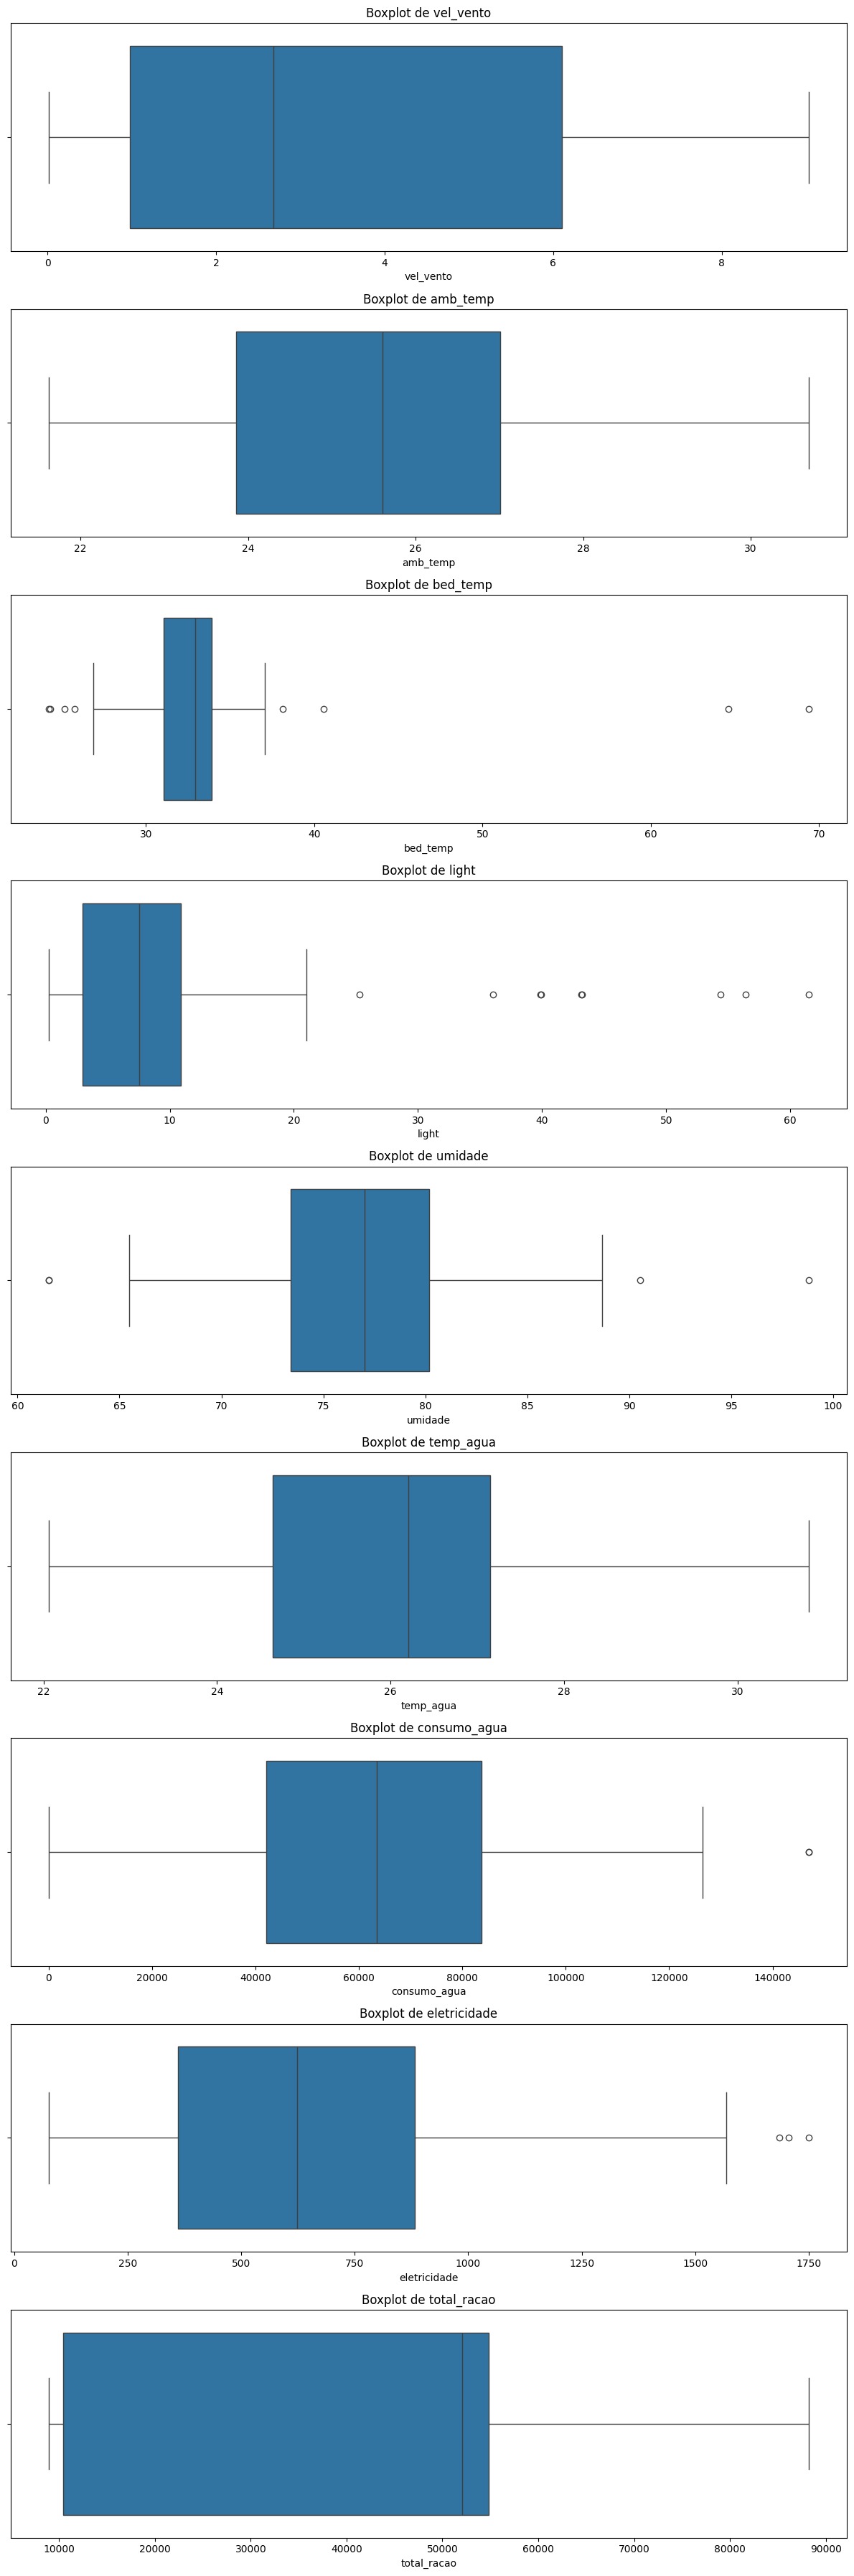

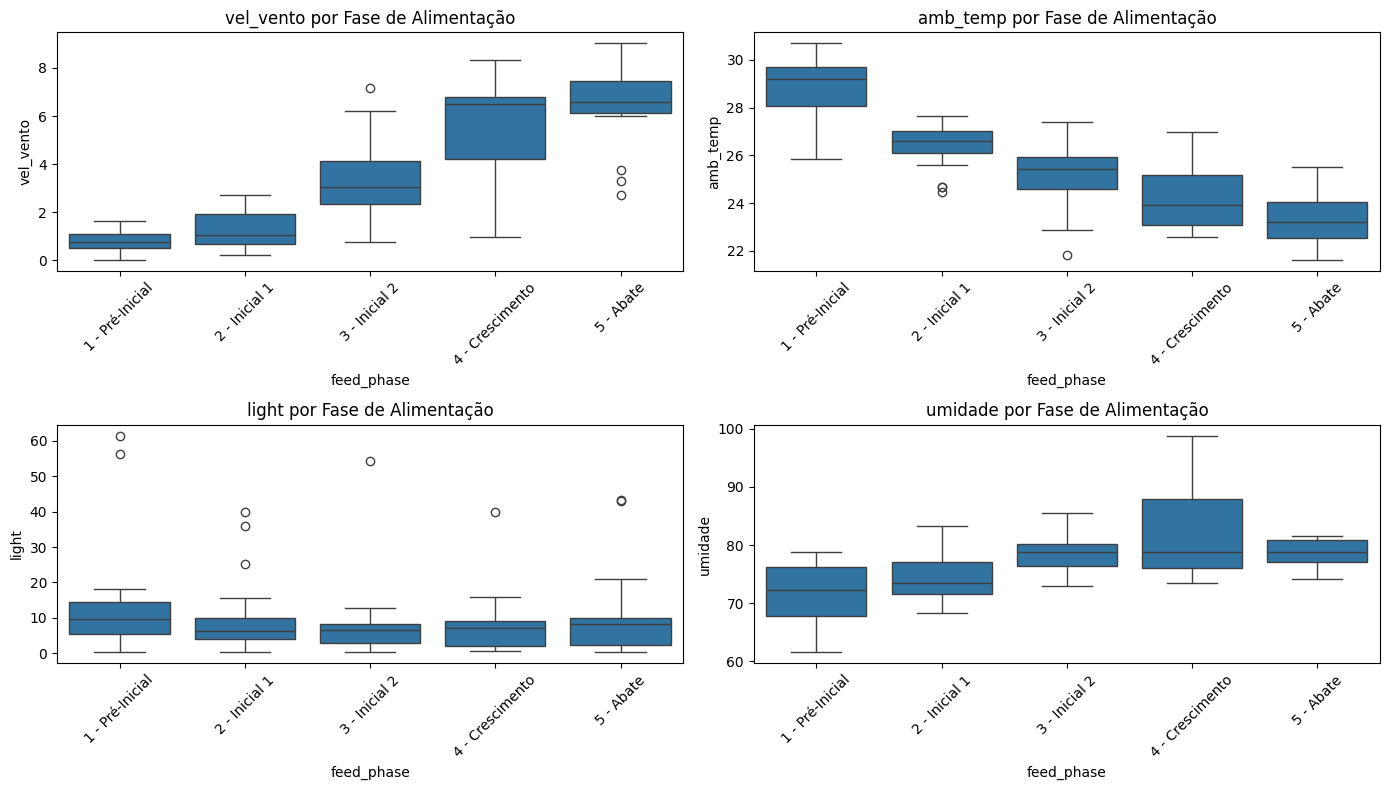

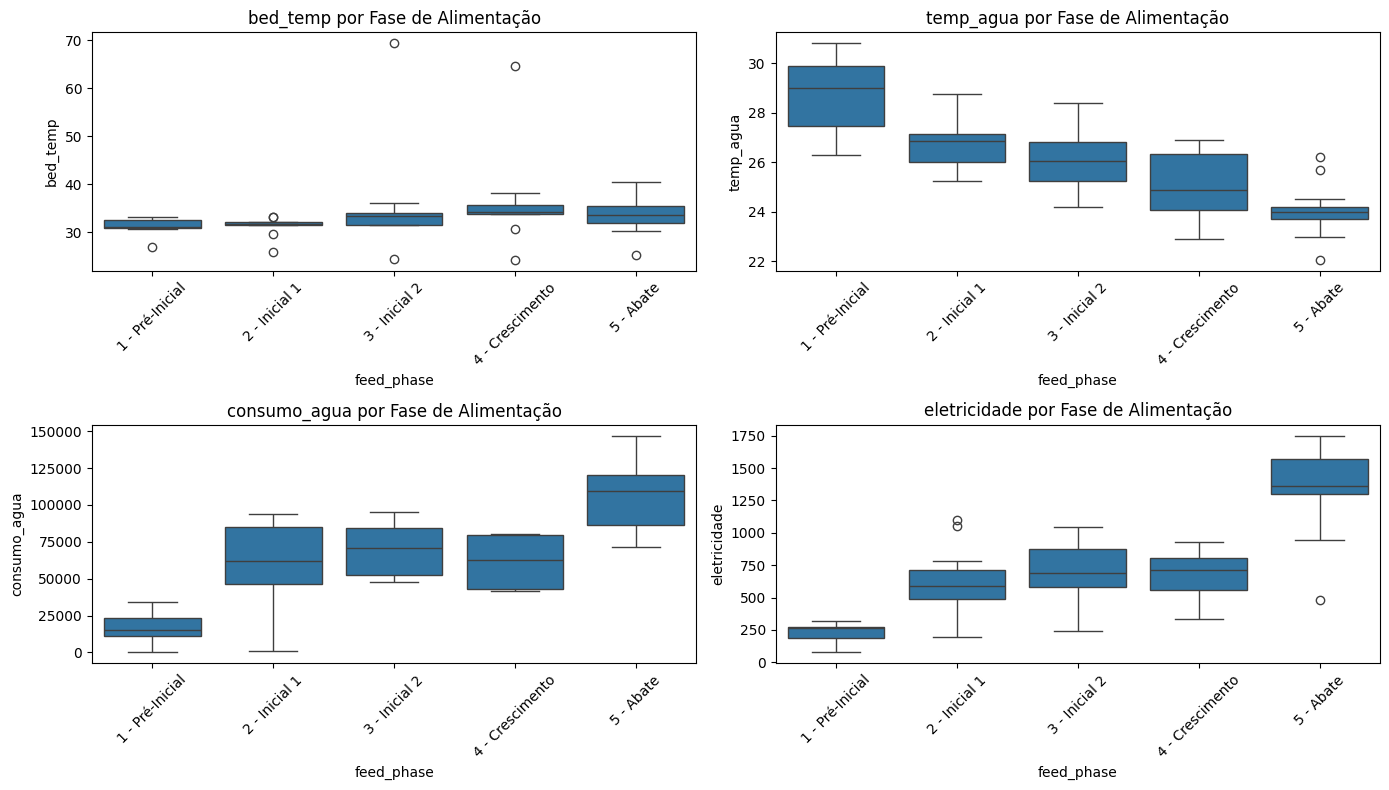

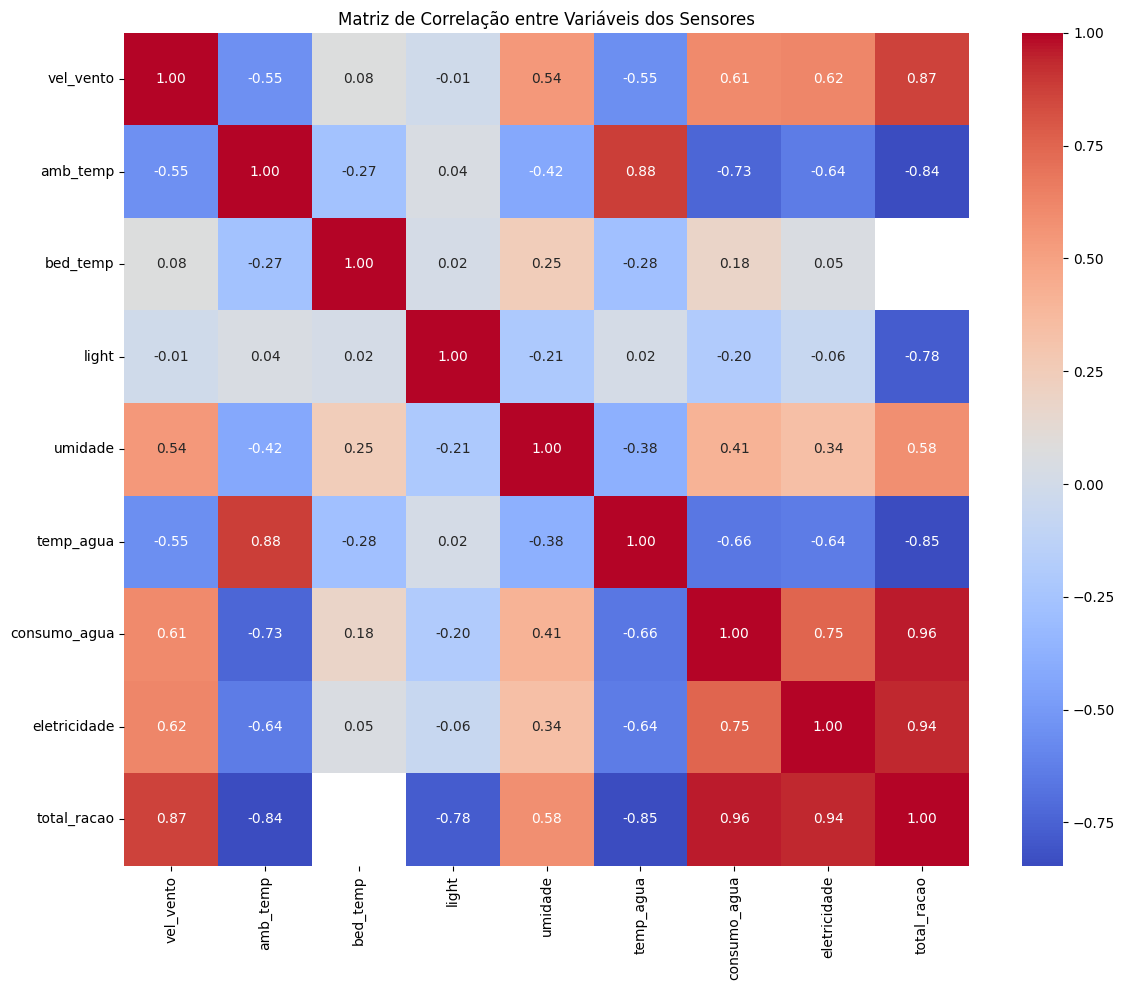

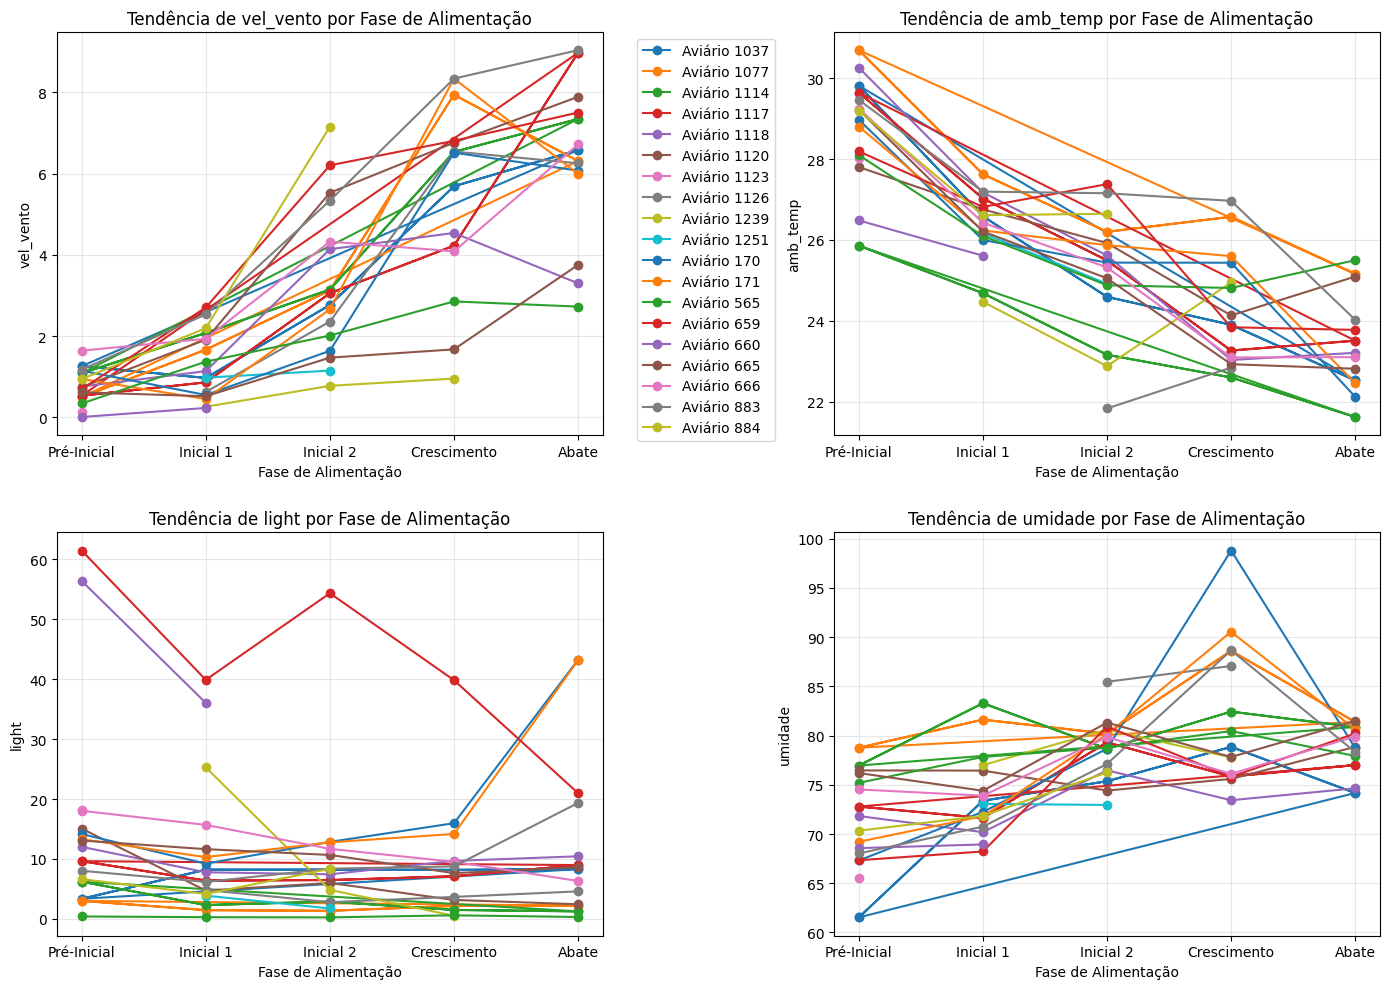

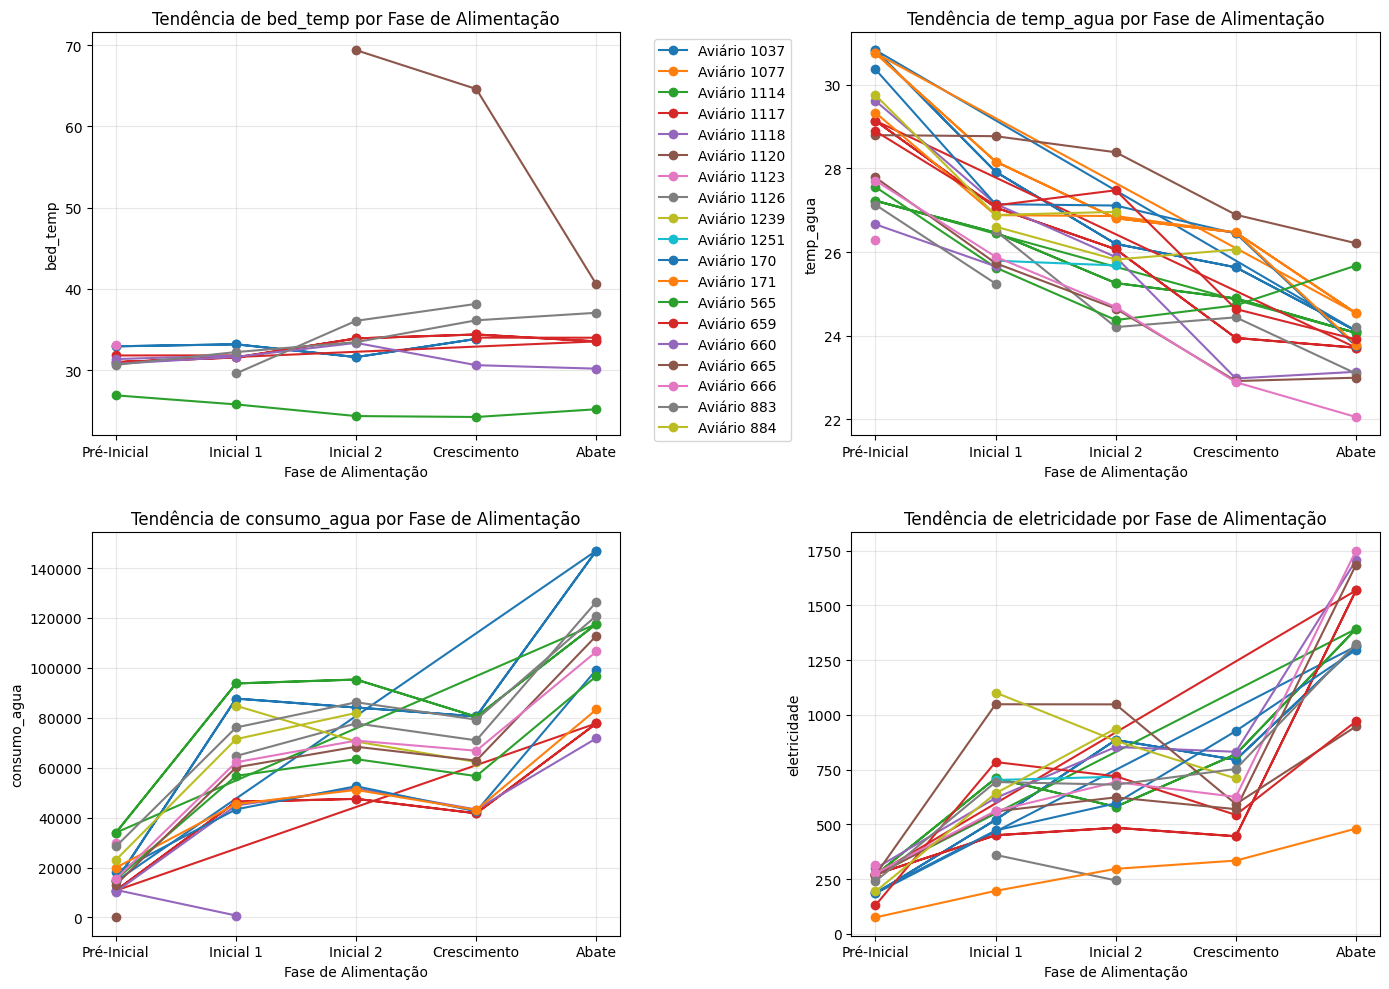

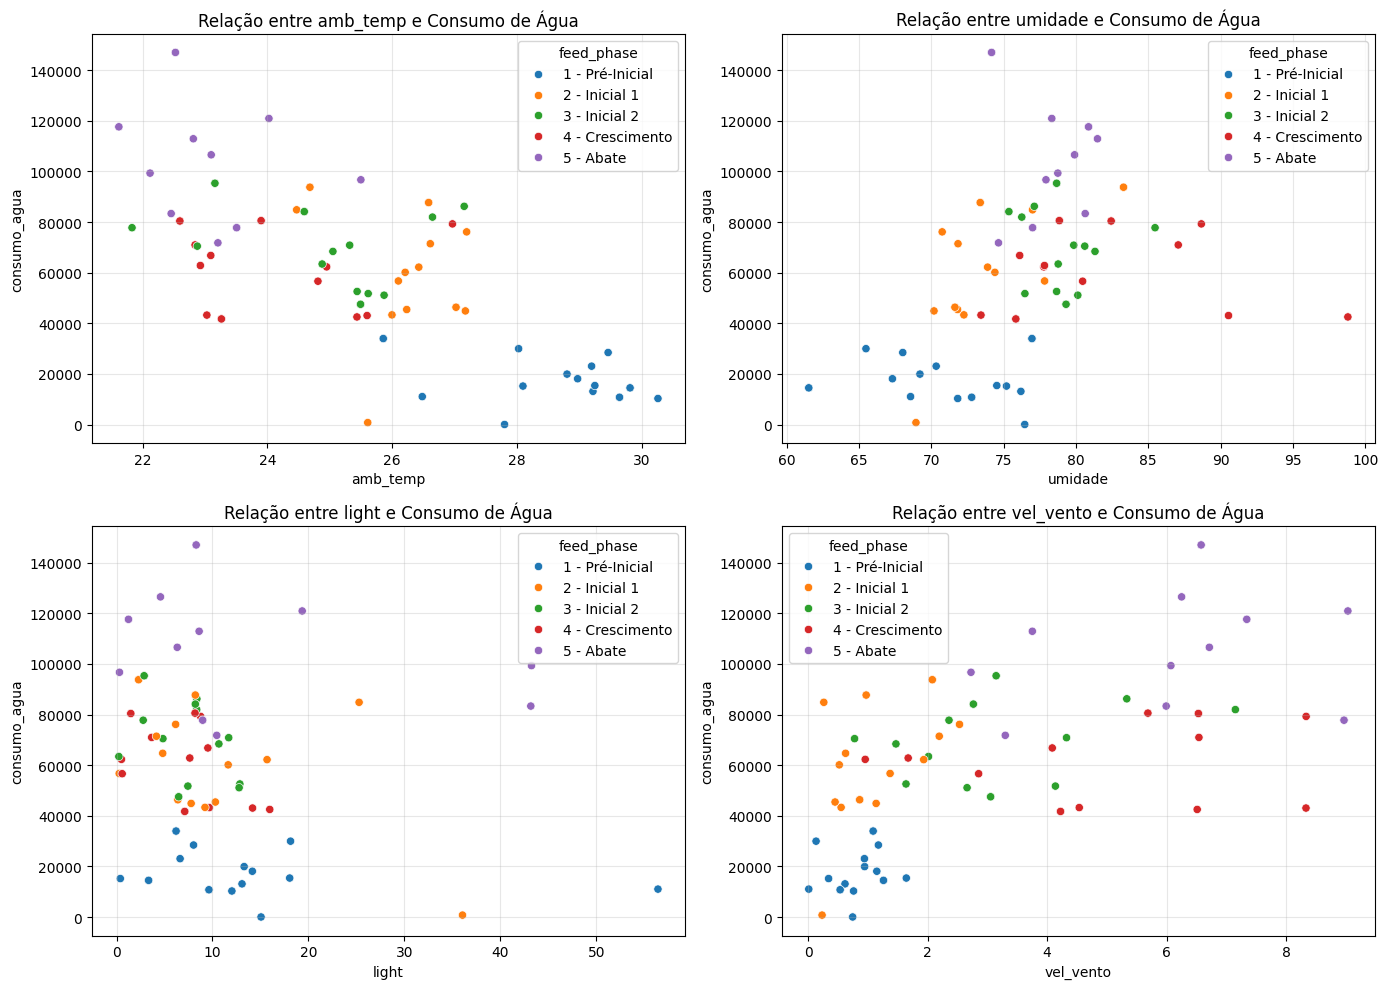

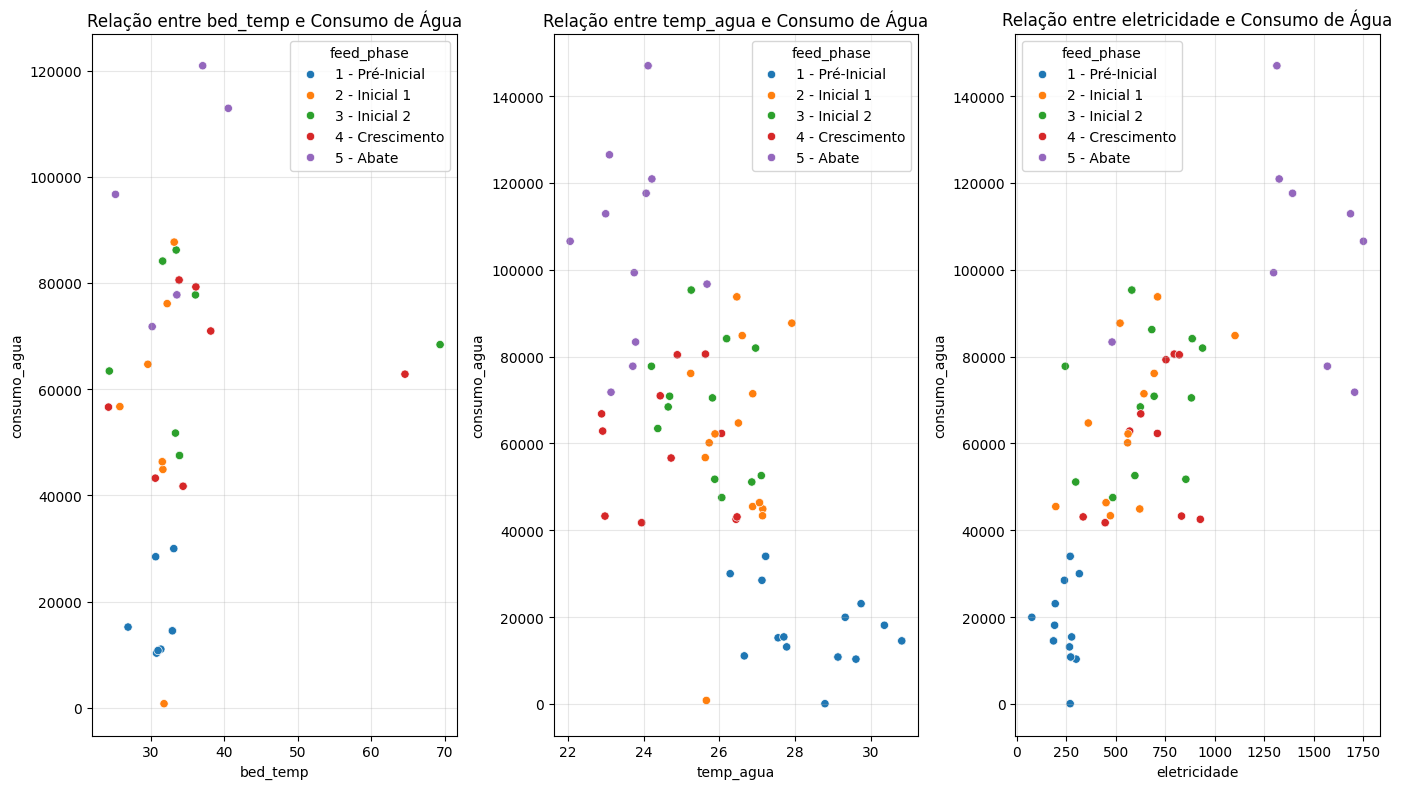

In [69]:
# Análise Exploratória dos Dados dos Sensores

# Importar bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visão geral dos dados
print("Forma dos dados:", sensores_df.shape)
print("\nInformações dos dados:")
print(sensores_df.info())

# 2. Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(sensores_df.describe())

# 3. Verificação de valores nulos
valores_nulos = sensores_df.isnull().sum()
print("\nValores nulos por coluna:")
print(valores_nulos)
print(f"Porcentagem de valores nulos no total: {sensores_df.isnull().sum().sum() / (sensores_df.shape[0] * sensores_df.shape[1]) * 100:.2f}%")

# 4. Distribuição das variáveis numéricas
colunas_numericas = sensores_df.select_dtypes(include=['float64']).columns
fig, axes = plt.subplots(len(colunas_numericas), 1, figsize=(12, 4 * len(colunas_numericas)))

for i, coluna in enumerate(colunas_numericas):
    sns.histplot(sensores_df[coluna].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição de {coluna}')
    axes[i].set_xlabel(coluna)
    
plt.tight_layout()
plt.show()

# 5. Boxplots para identificar outliers
fig, axes = plt.subplots(len(colunas_numericas), 1, figsize=(12, 4 * len(colunas_numericas)))

for i, coluna in enumerate(colunas_numericas):
    sns.boxplot(x=sensores_df[coluna].dropna(), ax=axes[i])
    axes[i].set_title(f'Boxplot de {coluna}')
    axes[i].set_xlabel(coluna)
    
plt.tight_layout()
plt.show()

# 6. Análise por fase de alimentação
plt.figure(figsize=(14, 8))
for i, coluna in enumerate(['vel_vento', 'amb_temp', 'light', 'umidade']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='feed_phase', y=coluna, data=sensores_df)
    plt.title(f'{coluna} por Fase de Alimentação')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

# Adicionar as novas variáveis para análise
plt.figure(figsize=(14, 8))
for i, coluna in enumerate(['bed_temp', 'temp_agua', 'consumo_agua', 'eletricidade']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='feed_phase', y=coluna, data=sensores_df)
    plt.title(f'{coluna} por Fase de Alimentação')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

# 7. Matriz de correlação
plt.figure(figsize=(12, 10))
corr_matrix = sensores_df.select_dtypes(include=['float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis dos Sensores')
plt.tight_layout()
plt.show()

# 8. Análise de tendências ao longo das fases de alimentação
# Criar um mapa numérico para as fases
fase_map = {
    '1 - Pré-Inicial': 1,
    '2 - Inicial 1': 2,
    '3 - Inicial 2': 3,
    '4 - Crescimento': 4,
    '5 - Abate': 5
}

# Converter a coluna feed_phase para valores numéricos para facilitar a visualização
sensores_df['fase_num'] = sensores_df['feed_phase'].map(fase_map)

# Plotar tendências para variáveis principais
plt.figure(figsize=(14, 10))
for i, coluna in enumerate(['vel_vento', 'amb_temp', 'light', 'umidade']):
    plt.subplot(2, 2, i+1)
    for aviario in sensores_df['aviario'].unique():
        dados_aviario = sensores_df[sensores_df['aviario'] == aviario]
        plt.plot(dados_aviario['fase_num'], dados_aviario[coluna], marker='o', label=f'Aviário {aviario}')
    plt.xlabel('Fase de Alimentação')
    plt.ylabel(coluna)
    plt.title(f'Tendência de {coluna} por Fase de Alimentação')
    plt.xticks(range(1, 6), ['Pré-Inicial', 'Inicial 1', 'Inicial 2', 'Crescimento', 'Abate'])
    if i == 0:  # Mostrar legenda apenas no primeiro gráfico
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plotar tendências para as novas variáveis
plt.figure(figsize=(14, 10))
for i, coluna in enumerate(['bed_temp', 'temp_agua', 'consumo_agua', 'eletricidade']):
    plt.subplot(2, 2, i+1)
    for aviario in sensores_df['aviario'].unique():
        dados_aviario = sensores_df[sensores_df['aviario'] == aviario]
        plt.plot(dados_aviario['fase_num'], dados_aviario[coluna], marker='o', label=f'Aviário {aviario}')
    plt.xlabel('Fase de Alimentação')
    plt.ylabel(coluna)
    plt.title(f'Tendência de {coluna} por Fase de Alimentação')
    plt.xticks(range(1, 6), ['Pré-Inicial', 'Inicial 1', 'Inicial 2', 'Crescimento', 'Abate'])
    if i == 0:  # Mostrar legenda apenas no primeiro gráfico
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Relação entre consumo de água e outras variáveis
plt.figure(figsize=(14, 10))
for i, coluna in enumerate(['amb_temp', 'umidade', 'light', 'vel_vento']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=coluna, y='consumo_agua', hue='feed_phase', data=sensores_df)
    plt.title(f'Relação entre {coluna} e Consumo de Água')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Relação entre as novas variáveis e consumo de água
plt.figure(figsize=(14, 8))
for i, coluna in enumerate(['bed_temp', 'temp_agua', 'eletricidade']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=coluna, y='consumo_agua', hue='feed_phase', data=sensores_df)
    plt.title(f'Relação entre {coluna} e Consumo de Água')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Average environmental values by feed phase:
        feed_phase  vel_vento      light
0  1 - Pré-Inicial   0.797022  14.054852
1    2 - Inicial 1   1.299160   9.842876
2    3 - Inicial 2   3.282450   8.566608
3  4 - Crescimento   5.586926   7.967464
4        5 - Abate   6.534150  11.160215

Correlations between feed consumption and environmental factors:
pre_inicial_total_racao: 1.0000
inicial_2_bed_temp: 0.7424
pre_inicial_eletricidade: -0.6264
crescimento_bed_temp: 0.5834
crescimento_amb_temp: -0.5586
inicial_1_consumo_agua: -0.5407
crescimento_umidade: -0.5029
inicial_1_light: 0.5005
crescimento_temp_agua: -0.4962
pre_inicial_light: 0.4821
inicial_1_vel_vento: -0.4546
inicial_1_amb_temp: -0.4486
inicial_1_umidade: -0.4439
pre_inicial_umidade: -0.4322
abate_vel_vento: 0.4169
inicial_1_eletricidade: -0.4078
inicial_2_consumo_agua: 0.3920
abate_temp_agua: 0.3632
crescimento_vel_vento: -0.3524
abate_consumo_agua: 0.3431
inicial_2_vel_vento: 0.3360
abate_umidade: -0.3028
abate_light: -0.2

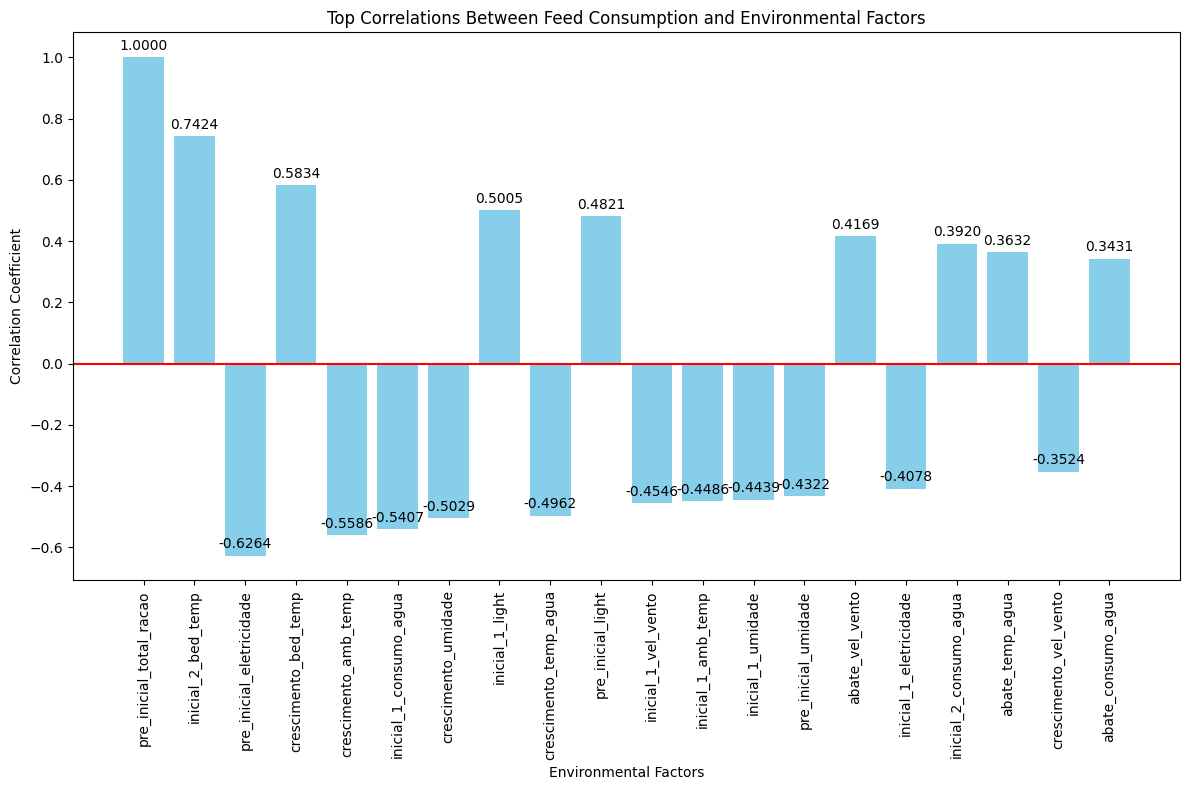

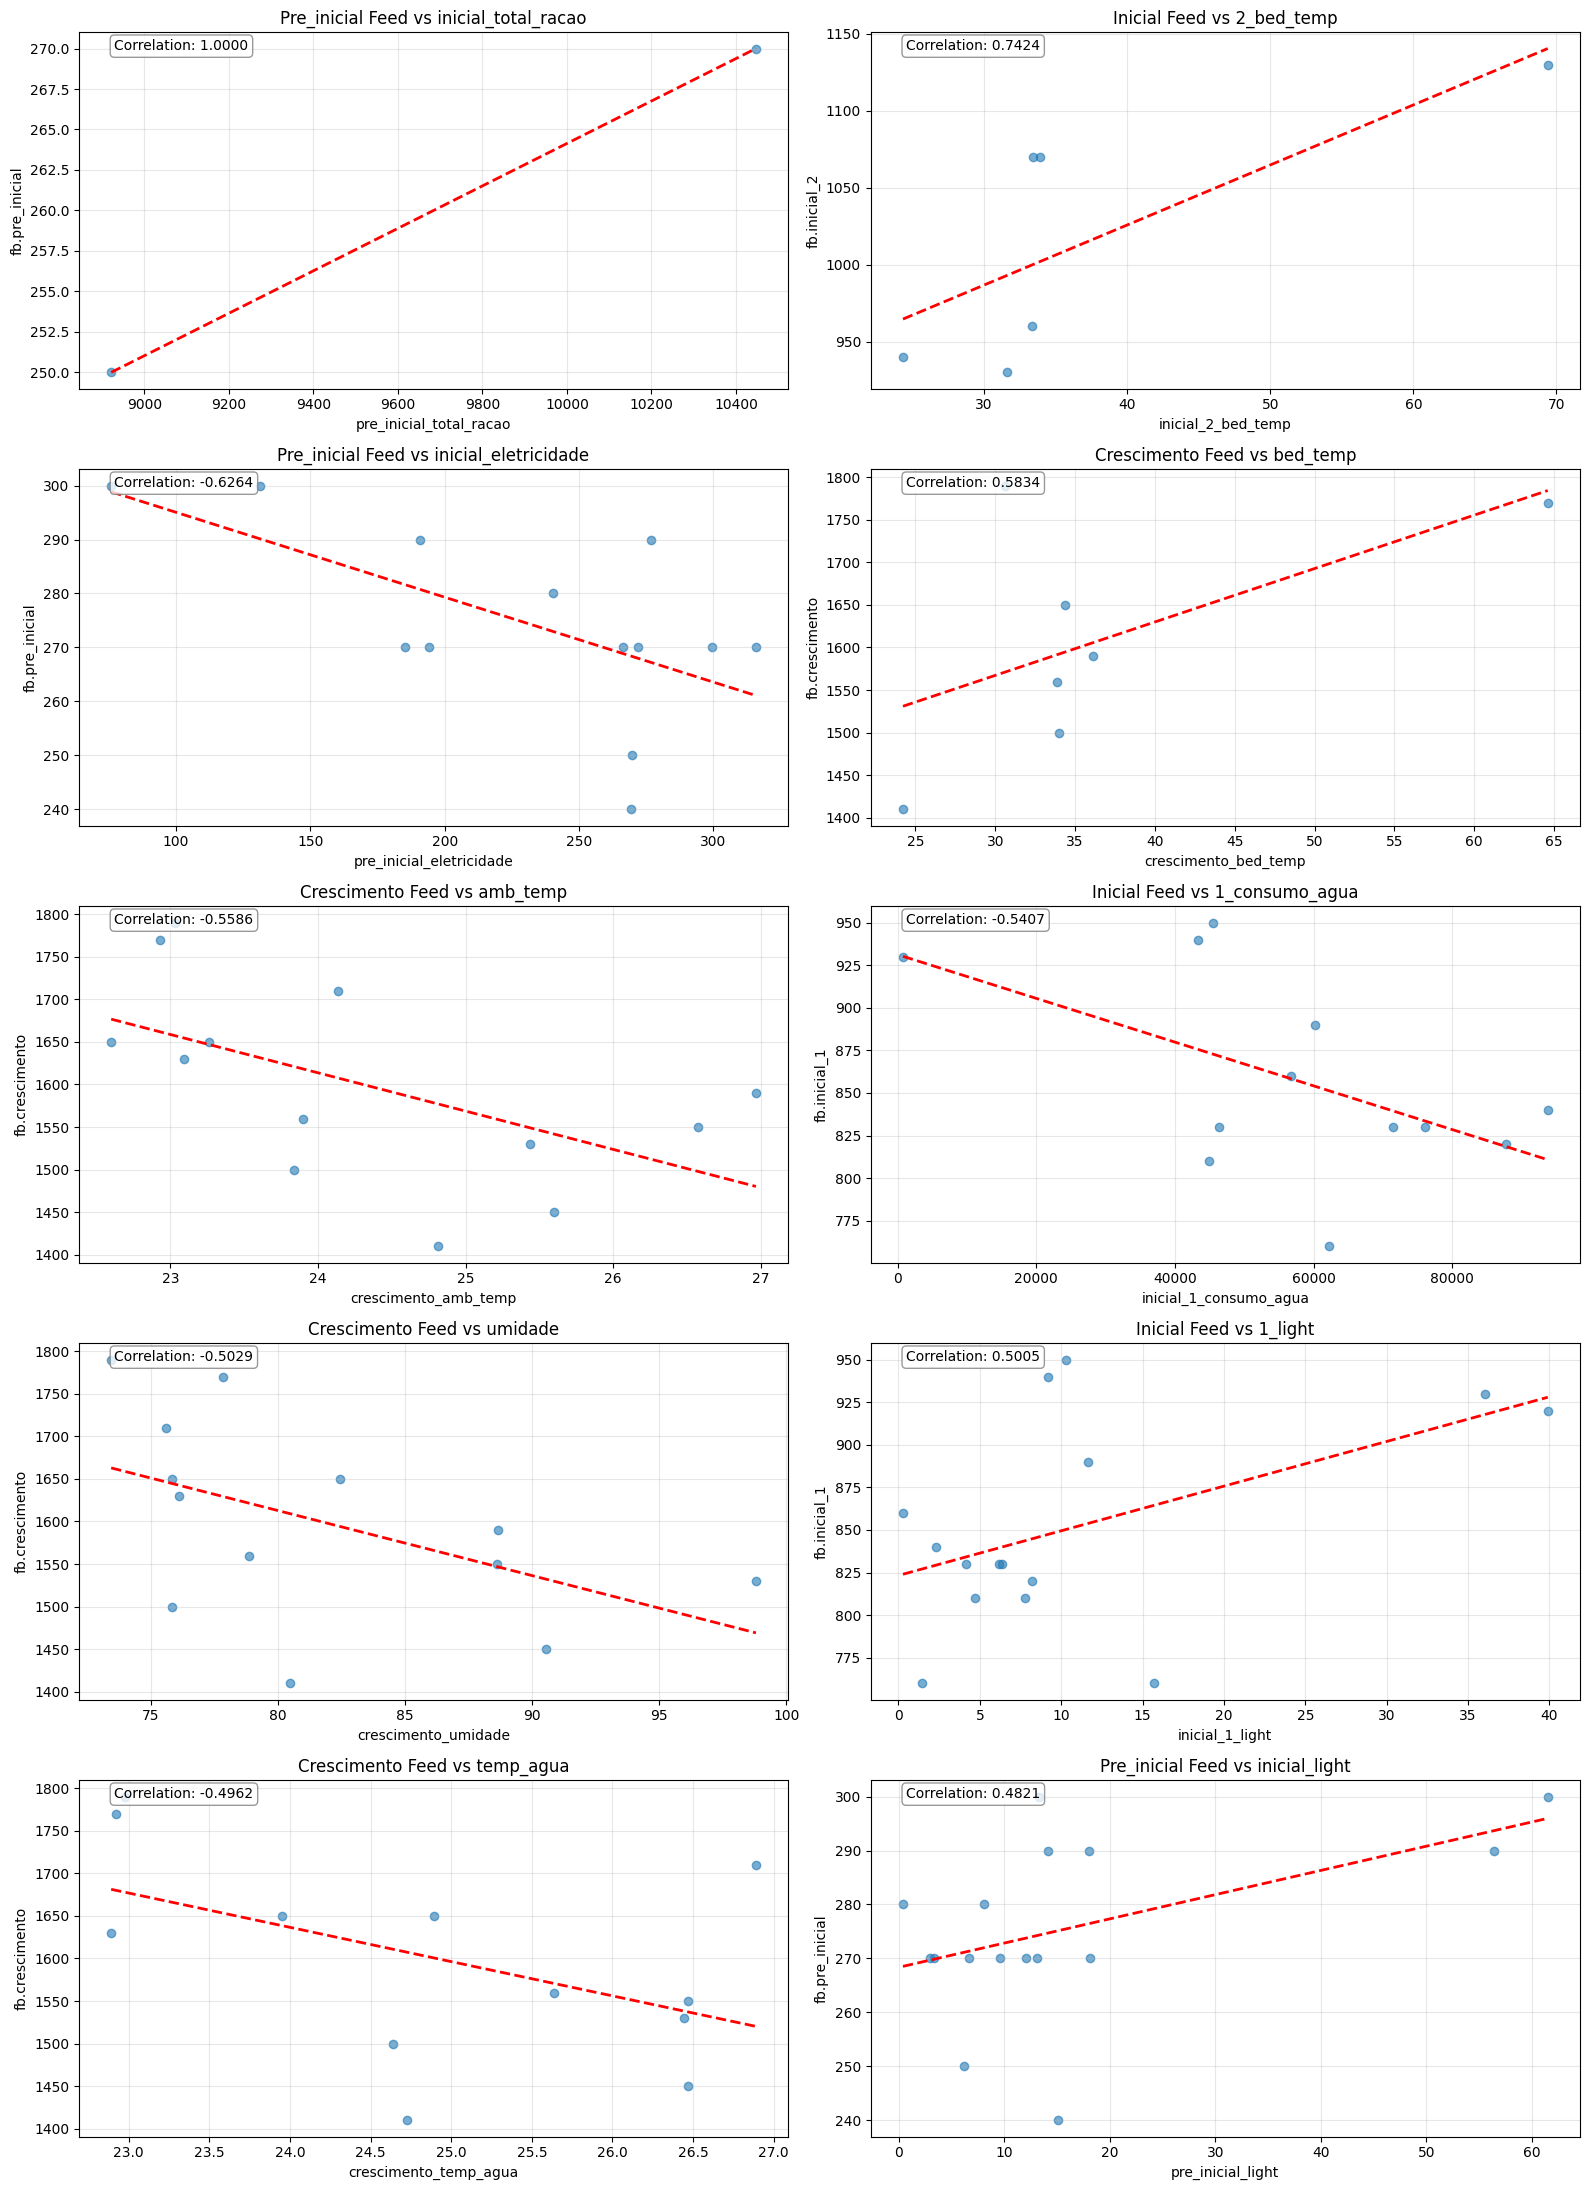

In [67]:
# Step 1: Extract the average feed values by feed_phase from the sensor data
feed_by_phase = sensores_df.groupby('feed_phase')[['vel_vento', 'light']].mean().reset_index()
print("Average environmental values by feed phase:")
print(feed_by_phase)

# Step 2: Calculate correlations between feed phases and feed consumption
# First, extract feed phase values from sensores_df
pre_inicial_data = sensores_df[sensores_df['feed_phase'] == '1 - Pré-Inicial']
inicial_1_data = sensores_df[sensores_df['feed_phase'] == '2 - Inicial 1']
inicial_2_data = sensores_df[sensores_df['feed_phase'] == '3 - Inicial 2']
crescimento_data = sensores_df[sensores_df['feed_phase'] == '4 - Crescimento']
abate_data = sensores_df[sensores_df['feed_phase'] == '5 - Abate']

# Create a new dataframe with aviario and the feed values for correlation analysis
aviario_feed_df = pd.DataFrame()

# Process all feed phase data
for phase_data, phase_prefix in [
    (pre_inicial_data, 'pre_inicial'),
    (inicial_1_data, 'inicial_1'),
    (inicial_2_data, 'inicial_2'),
    (crescimento_data, 'crescimento'),
    (abate_data, 'abate')
]:
    # Try to convert numeric columns
    for col in ['vel_vento', 'light', 'amb_temp', 'bed_temp', 'umidade', 'temp_agua', 'consumo_agua', 'eletricidade', 'total_racao']:
        if col in phase_data.columns:
            try:
                # Convert to numeric, coerce errors to NaN
                phase_data[col] = pd.to_numeric(phase_data[col], errors='coerce')
                # Calculate mean by aviario
                if not phase_data[col].isna().all():  # Check if column has any non-null values
                    aviario_feed_df[f'{phase_prefix}_{col}'] = phase_data.groupby('aviario')[col].mean()
            except:
                pass

# Reset index to make aviario a column
aviario_feed_df = aviario_feed_df.reset_index()

# Merge with the main dataframe to analyze correlations
merged_df = pd.merge(df, aviario_feed_df, left_on='fazenda', right_on='aviario', how='inner')

# Calculate correlations for all phases
correlations = {}
for phase_prefix, feed_col in [
    ('pre_inicial', 'fb.pre_inicial'), 
    ('inicial_1', 'fb.inicial_1'),
    ('inicial_2', 'fb.inicial_2'),
    ('crescimento', 'fb.crescimento'),
    ('abate', 'fb.abate')
]:
    for col in aviario_feed_df.columns:
        if col.startswith(f'{phase_prefix}_') and col != f'{phase_prefix}_feed_phase':
            try:
                # Only calculate correlation if both columns have valid data
                valid_data = merged_df[[feed_col, col]].dropna()
                if len(valid_data) > 1:  # Need at least 2 points for correlation
                    corr = valid_data[feed_col].corr(valid_data[col])
                    correlations[col] = corr
            except:
                pass

# Sort the correlations by absolute value
sorted_correlations = {k: v for k, v in sorted(correlations.items(), 
                                             key=lambda item: abs(item[1]), 
                                             reverse=True)}

# Display the correlations
print("\nCorrelations between feed consumption and environmental factors:")
for factor, corr in sorted_correlations.items():
    print(f"{factor}: {corr:.4f}")

# Visualize the top correlations
plt.figure(figsize=(12, 8))
top_correlations = dict(list(sorted_correlations.items())[:20])
bars = plt.bar(top_correlations.keys(), top_correlations.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Environmental Factors')
plt.ylabel('Correlation Coefficient')
plt.title('Top Correlations Between Feed Consumption and Environmental Factors')
plt.axhline(y=0, color='r', linestyle='-')

# Add correlation values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create scatter plots for the strongest correlations
top_factors = list(sorted_correlations.keys())[:10]
fig, axes = plt.subplots(5, 2, figsize=(16, 22))
axes = axes.flatten()

for i, factor in enumerate(top_factors):
    # Extract phase prefix from factor name
    phase_parts = factor.split('_')
    if phase_parts[0] == 'pre':
        phase_prefix = 'pre_inicial'
        y_col = 'fb.pre_inicial'
    else:
        phase_prefix = phase_parts[0]
        y_col = f'fb.{phase_prefix}'
        
    env_factor = '_'.join(phase_parts[1:])  # Get the environmental factor name
    title = f'{phase_prefix.capitalize()} Feed vs {env_factor}'
    
    # Determine the correct column name based on the phase prefix
    if phase_prefix == 'pre_inicial':
        y_col = 'fb.pre_inicial'
    elif phase_prefix == 'inicial':
        # Check if we're dealing with inicial_1 or inicial_2 based on the factor name
        if '_1_' in factor:
            y_col = 'fb.inicial_1'
        elif '_2_' in factor:
            y_col = 'fb.inicial_2'
        else:
            # Default to inicial_1 if can't determine
            y_col = 'fb.inicial_1'
    else:
        y_col = f'fb.{phase_prefix}'
    
    axes[i].scatter(merged_df[factor], merged_df[y_col], alpha=0.6)
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel(y_col)
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    
    # Add trendline - making sure we use only valid data points
    valid_mask = merged_df[[factor, y_col]].notna().all(axis=1)
    valid_x = merged_df[factor][valid_mask]
    valid_y = merged_df[y_col][valid_mask]
    
    if len(valid_x) > 1:  # Make sure we have at least 2 points to fit a line
        z = np.polyfit(valid_x, valid_y, 1)
        p = np.poly1d(z)
        x_sorted = sorted(valid_x)
        axes[i].plot(x_sorted, p(x_sorted), "r--", linewidth=2)
    
    # Add correlation value to plot
    if valid_mask.any():  # Only calculate if we have valid data
        corr = merged_df[factor][valid_mask].corr(merged_df[y_col][valid_mask])
        axes[i].annotate(f'Correlation: {corr:.4f}', 
                       xy=(0.05, 0.95), 
                       xycoords='axes fraction', 
                       fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


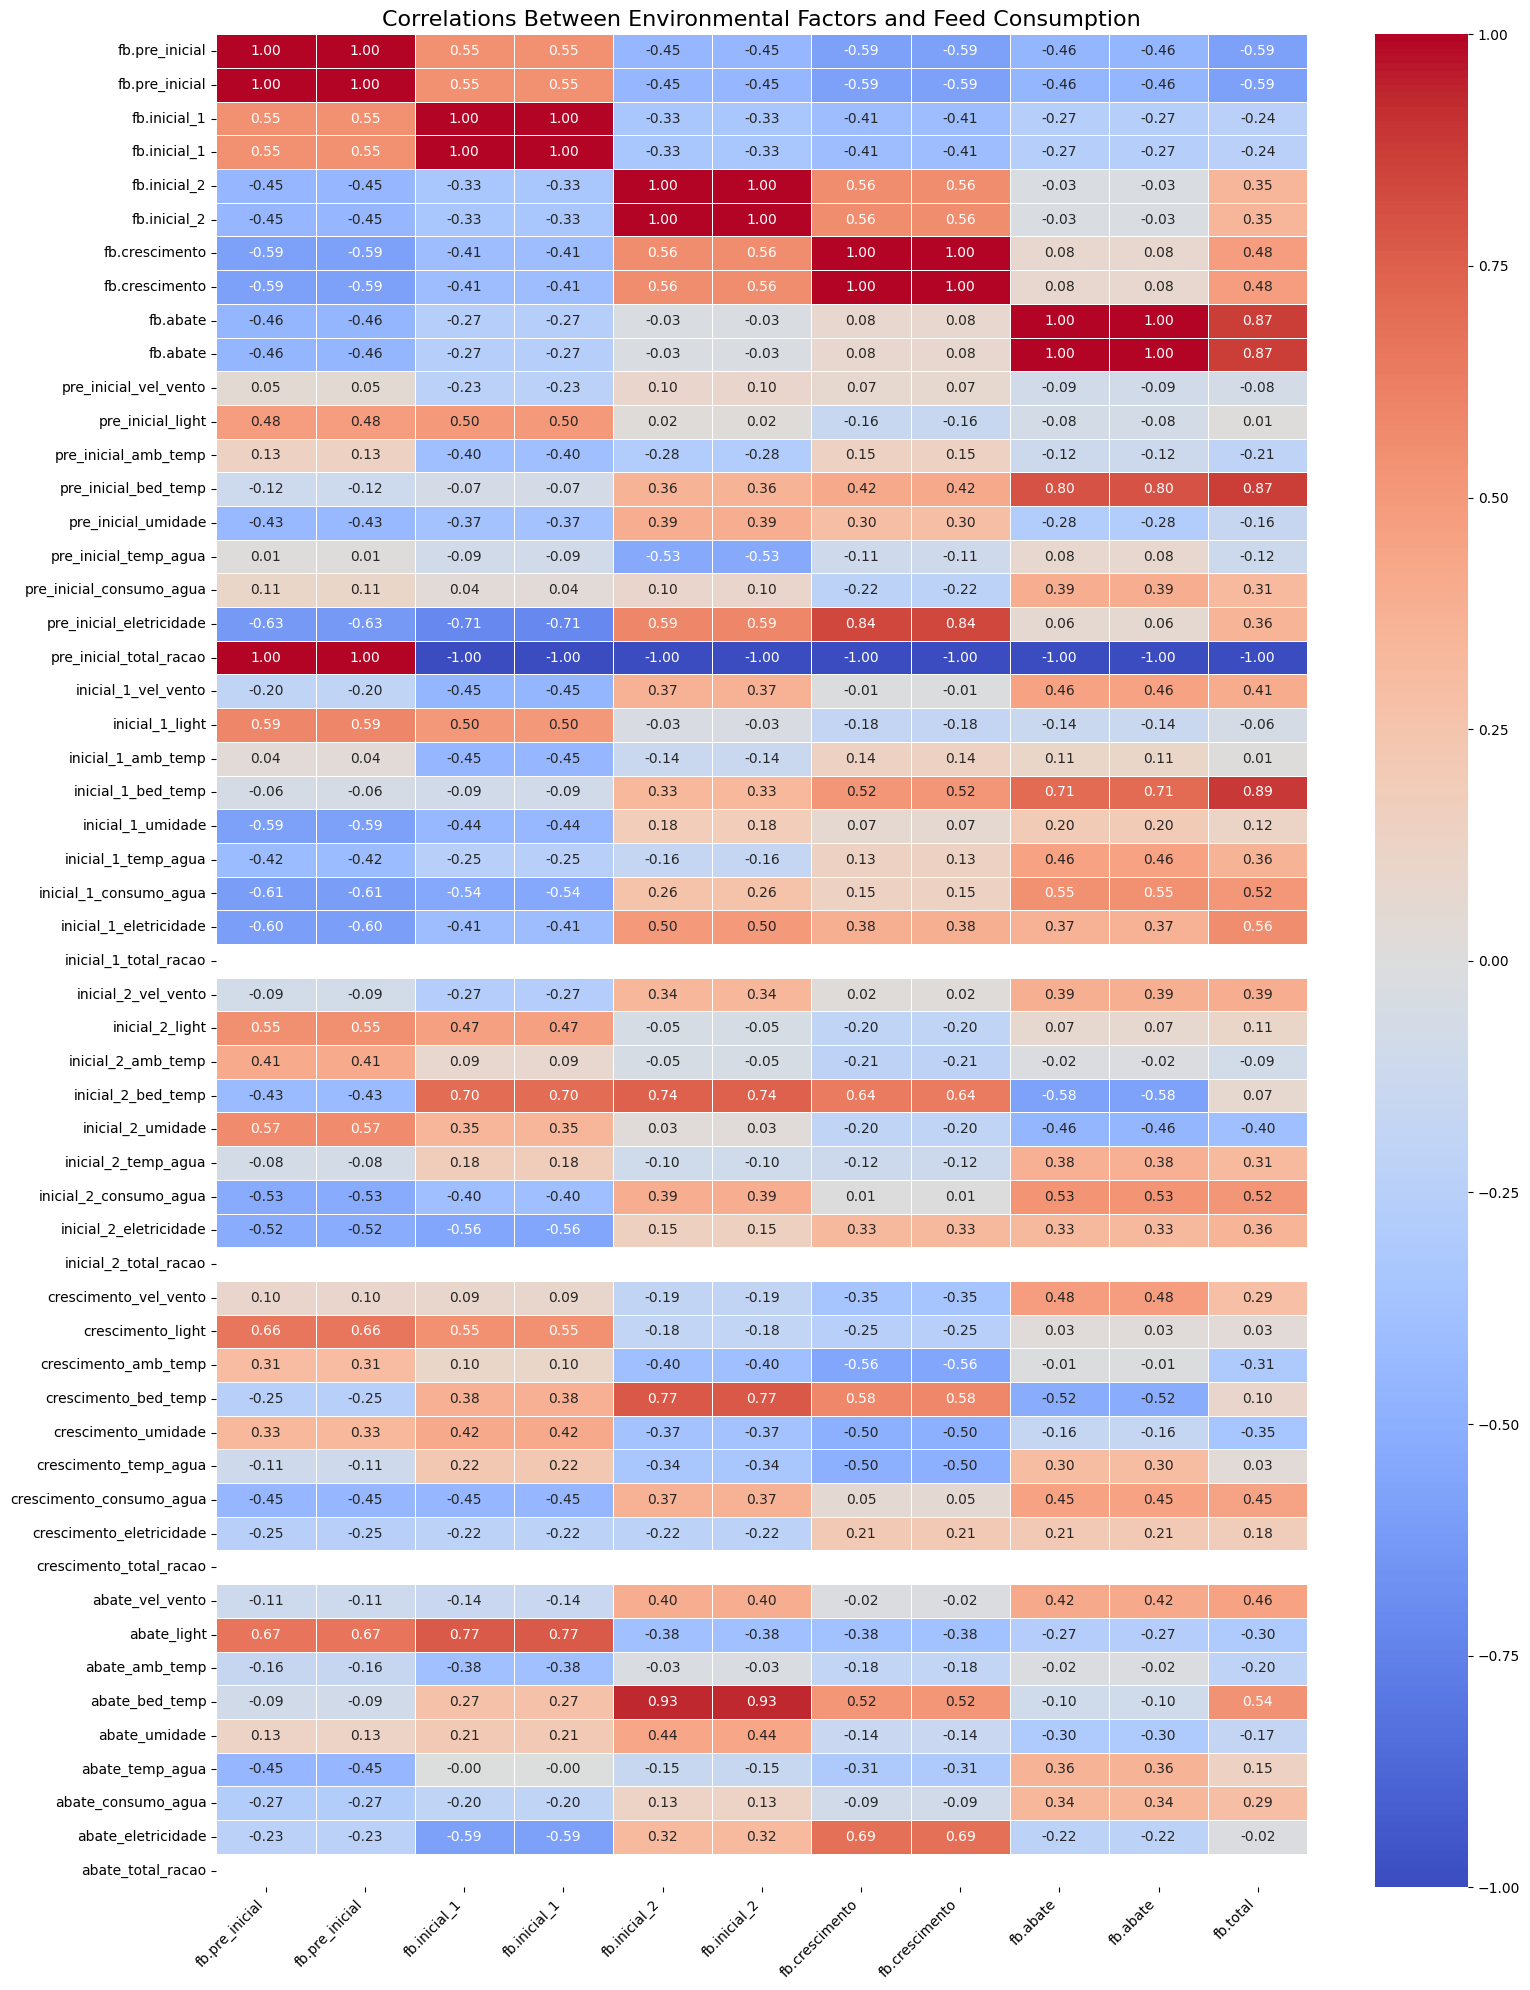

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Create correlation matrix between sensor data and feed consumption columns
# First, let's identify and remove duplicate columns in our merged dataframe
feed_columns = [col for col in merged_df.columns if col.startswith('fb.')]
unique_feed_columns = []

# Get a list of unique feed column names (removing duplicates)
for col in feed_columns:
    if col not in unique_feed_columns:
        unique_feed_columns.append(col)

# Select sensor columns - these are columns starting with phase names
sensor_columns = [col for col in merged_df.columns if any(phase in col for phase in 
                 ['pre_inicial', 'inicial_1', 'inicial_2', 'crescimento', 'abate'])]

# Create a dataframe with only these columns for correlation analysis
corr_df = merged_df[sensor_columns + unique_feed_columns].copy()

# Calculate correlation matrix
sensor_feed_corr = corr_df.corr()

# Extract only the correlations between sensor data and feed consumption
sensor_feed_corr_subset = sensor_feed_corr.loc[sensor_columns, unique_feed_columns]

# Plot the correlation matrix with a clearer visualization
plt.figure(figsize=(16, 20))
sns.heatmap(sensor_feed_corr_subset, annot=True, cmap='coolwarm', fmt=".2f", 
            vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title('Correlations Between Environmental Factors and Feed Consumption', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Find the strongest positive and negative correlations
correlations_flat = []
for sensor in sensor_columns:
    for feed in unique_feed_columns:
        corr_value = sensor_feed_corr.loc[sensor, feed]
        # Check if corr_value is a scalar or Series, handle appropriately
        if isinstance(corr_value, pd.Series):
            # If it's a Series, filter out NaN values and append each valid pair
            for idx, val in corr_value.items():
                if pd.notna(val):
                    correlations_flat.append((sensor, idx, val))
        else:
            # For scalar values, just check if not NaN
            if pd.notna(corr_value):
                correlations_flat.append((sensor, feed, corr_value))

# Sort by absolute correlation value
correlations_flat.sort(key=lambda x: abs(x[2]), reverse=True)

# Display top 20 strongest correlations
print("Top 20 strongest correlations between environmental factors and feed consumption:")
for sensor, feed, corr in correlations_flat[:20]:
    print(f"{sensor:<25} vs {feed:<15}: {corr:.4f}")

# Create scatter plots for the top 6 strongest correlations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, (sensor, feed, corr) in enumerate(correlations_flat[:6]):
    if i < 6:  # Only plot the top 6
        ax = axes[i]
        ax.scatter(merged_df[sensor], merged_df[feed], alpha=0.7)
        ax.set_title(f"{sensor} vs {feed} (r = {corr:.4f})")
        ax.set_xlabel(sensor)
        ax.set_ylabel(feed)
        
        # Add trend line
        valid_mask = merged_df[[sensor, feed]].notna().all(axis=1)
        if valid_mask.sum() > 1:  # Need at least 2 points for regression
            valid_x = merged_df[sensor][valid_mask]
            valid_y = merged_df[feed][valid_mask]
            
            z = np.polyfit(valid_x, valid_y, 1)
            p = np.poly1d(z)
            x_sorted = sorted(valid_x)
            ax.plot(x_sorted, p(x_sorted), "r--", linewidth=2)
            
            # Add equation to plot
            equation = f"y = {z[0]:.2f}x + {z[1]:.2f}"
            ax.annotate(equation, xy=(0.05, 0.05), xycoords='axes fraction', 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Additional analysis: Group correlations by feed phase for better interpretation
phases = ['pre_inicial', 'inicial_1', 'inicial_2', 'crescimento', 'abate']
factors = ['vel_vento', 'light', 'amb_temp', 'bed_temp', 'umidade', 'temp_agua', 'consumo_agua', 'eletricidade']

# Create a summary DataFrame to show the strongest factor for each feed phase
summary_data = []
for phase in phases:
    for factor in factors:
        col_name = f"{phase}_{factor}"
        # Check if this column exists in our data
        if col_name in sensor_columns:
            for feed_col in unique_feed_columns:
                if col_name in sensor_feed_corr_subset.index and feed_col in sensor_feed_corr_subset.columns:
                    corr_value = sensor_feed_corr_subset.loc[col_name, feed_col]
                    if not np.isnan(corr_value):
                        summary_data.append({
                            'Phase': phase,
                            'Environmental Factor': factor,
                            'Feed Column': feed_col,
                            'Correlation': corr_value
                        })

summary_df = pd.DataFrame(summary_data)

# Create a pivot table to show the strongest correlations by phase and factor
best_correlations = summary_df.loc[summary_df.groupby(['Phase', 'Environmental Factor'])['Correlation'].abs().idxmax()]
pivot_table = best_correlations.pivot_table(
    index=['Phase', 'Environmental Factor'], 
    values='Correlation',
    columns='Feed Column',
    aggfunc='first'
)

# Plot this as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Strongest Correlations Between Environmental Factors and Feed Consumption by Phase')
plt.tight_layout()
plt.show()